<a href="https://colab.research.google.com/github/katerinavr/ml-tutes/blob/master/CoPairsPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script will try to compare various outlier detection algorithms to find the the best fitting learning curve using all the selected important dragon features. Then the fitted model will be implemented to rank the unknown pairs from Zinc15 database.

-Feature Engineering:
  - Drop descriptors that are highly correlated (>0.92)
  - Drop the descriptors with very low variance (<0.4)
  - Keep only highly pairwise correlated features (>0.3 Spearman correlation, >0.2 Pearson correlation)
  
-Feature interaction :
  - Substuction
  

In [1]:
# Import the main libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [0]:
# Code to read csv files into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link1='https://drive.google.com/open?id=1Uk3l-a29R-WNrJ3uFTXJcqmT-LTGCU3h' 
fluff, id = link1.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('datafil1.csv') 
dataset1=pd.read_csv('datafil1.csv') 
print(dataset1.shape)

1Uk3l-a29R-WNrJ3uFTXJcqmT-LTGCU3h
(1738, 1859)


In [4]:
# Import the dataset which contains all the molecules that constitute the second coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link2='https://drive.google.com/open?id=1E_bttrVh_4Igzs_esb1lKDfaA204X2SB'
fluff, id = link2.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('datafil2.csv') 
dataset2=pd.read_csv('datafil2.csv')
print(dataset2.shape)

1E_bttrVh_4Igzs_esb1lKDfaA204X2SB
(1738, 1859)


In [5]:
# Create a dictionary where all the combinations of molecules that form co-crystals are assigned to their molecular ratios and Z'

linkaki='https://drive.google.com/open?id=19kMNPNzm0hURmCjdq28dbnJVdWH8CD9Z'
fluff, id = linkaki.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ready.csv') 
dictionar=pd.read_csv('ready.csv')
keys = dictionar.iloc[:, 0].values
values = dictionar.iloc[:, 3:7].values
d = {key:value for key, value in zip(keys, values)}

# Using the dictonary each molecular combination in the initial datasets

19kMNPNzm0hURmCjdq28dbnJVdWH8CD9Z


In [0]:
ratios=[]
for x in dataset2['Identifier'].values:
  ratios.append(d[x])  
ratio=pd.DataFrame(ratios, columns=['Z', 'mol1', 'mol2', 'ratios'])  
rat=pd.concat([dataset2 ,ratio], axis=1)


In [7]:
dataset = rat.drop(['mol1', 'mol2'], axis=1)
#dataset.shape
d2=dataset.drop(['Identifier', 'NAME'], axis=1)
d1= dataset1.insert(loc=2, column='NAME2', value=dataset['NAME'])


dataset=pd.concat([dataset1, d2], axis=1)
#dataset.head()
print(dataset1.head())

  Identifier  ... Infective-50
0     WOVMEB  ...          0.0
1     PIWKEL  ...          1.0
2     OTIHIJ  ...          0.0
3     DABLOJ  ...          0.0
4     PIGJUK  ...          0.0

[5 rows x 1860 columns]


In [8]:
dataset.head()

,Identifier,NAME,NAME2,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,nAT,nSK,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nHM,nHet,nX,H%,C%,N%,O%,...,AMR,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,ALOGP,ALOGP2,SAtot,SAacc,Vx,VvdwMG,VvdwZAZ,PDI,BLTF96,BLTD48,BLTA96,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02,CMC-80,CMC-50,Inflammat-80,Inflammat-50,Depressant-80,Psychotic-80,Hypertens-80,Hypnotic-80,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50,Z,ratios
0,WOVMEB,Cc1ccccc1C,C[Si](C)(C)C1=C2SC3=C(C4=C(S3)C3=C(S4)C(=C(SC4...,106.18,5.899,10.634,17.418,11.807,20.076,0.591,0.968,0.656,1.115,18,8,18,8,6,11.0,0,0.000,0,0,6,10,8,0,0,0,0,0,0,0,0,0,0,55.6,44.4,0.0,0.0,...,373.936,0.00,451.84,12.230,149.561,30.740,944.948,NaN,NaN,1740.997,716.900,1212.98,NaN,-11.79,-12.94,-13.46,0,0.5,0.33,0.67,0.5,0.0,0.5,0.50,0.33,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
1,PIWKEL,O=C1C=CC2=C(C=C1)C(=O)C1=C(C=CC(=O)C=C1)C2=O,S1C=CSC1=C1SC=CS1,264.24,9.437,20.966,28.844,20.864,30.498,0.749,1.030,0.745,1.089,28,20,30,22,10,32.0,0,0.000,10,0,0,8,16,0,4,0,0,0,0,0,0,4,0,28.6,57.1,0.0,14.3,...,55.178,0.00,112.96,2.399,5.755,1.700,2.891,207.328,0.000,209.601,89.279,153.76,1.011,-3.43,-3.60,-3.63,1,1.0,0.67,1.00,0.3,0.0,1.0,0.71,0.83,0.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1
2,OTIHIJ,CN(C)c1ccc(cc1)C(C(C1=CC=C2C=CC=CC=C12)C1=C2C=...,c1ccccc1,520.76,6.852,48.998,74.225,52.955,84.055,0.645,0.977,0.697,1.106,76,40,81,45,34,62.0,7,0.086,0,0,34,36,38,2,0,0,0,0,0,0,0,2,0,47.4,50.0,2.6,0.0,...,26.058,0.00,0.00,2.255,5.085,1.830,3.349,127.484,0.000,119.003,52.149,81.18,0.933,-3.31,-3.46,-3.48,1,1.0,0.50,0.83,0.5,0.0,1.0,0.69,1.00,0.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
3,DABLOJ,CCOC(C)=O,CC(C)C1=CC=C(C)C2=C(C=C(C)C2=C1)C1C=CC(c2ccc(c...,88.12,6.294,7.537,14.189,7.955,16.080,0.538,1.014,0.568,1.149,14,6,13,5,1,6.0,2,0.154,1,0,0,8,4,0,2,0,0,0,0,0,0,2,0,57.1,28.6,0.0,14.3,...,153.995,98.40,98.40,3.515,12.354,6.585,43.357,729.359,127.362,679.718,281.950,507.44,0.932,-4.38,-4.66,-4.74,1,1.0,0.83,1.00,0.8,0.5,1.0,0.88,0.17,0.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
4,PIGJUK,CSC1=Cc2ccc3SC(=Cc4ccc(S1)c2c34)SC,N#CC(C#N)=C1C=CC2=CC(C=CC2=C1)=C(C#N)C#N,332.56,10.393,23.909,31.607,27.159,34.171,0.747,0.988,0.849,1.068,32,20,35,23,13,30.5,2,0.057,2,0,11,12,16,0,0,0,4,0,0,0,4,4,0,37.5,50.0,0.0,0.0,...,79.385,95.16,95.16,0.677,0.458,1.772,3.140,337.242,124.237,322.757,135.655,267.68,0.957,-1.97,-1.96,-1.91,1,1.0,0.83,1.00,0.4,0.0,1.0,0.75,0.67,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1


In [30]:
df1_w=dataset1.iloc[:,3:]
df2_w=dataset2.iloc[:,2:]
data = pd.concat([df1_w, df2_w])
data_ = data.drop_duplicates(keep='first')
print(df1_w.shape)
print(df2_w.shape)


(1738, 1857)
(1738, 1857)


In [10]:
# Drop the highly linearly correlated features among the datasets
# Create correlation matrix

corr_matrix1 = df1_w.corr().abs()
corr_matrix2 = df2_w.corr().abs()

# Select upper triangle of correlation matrix
upper1 = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))
upper2 = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))


# Find index of feature columns with Pearson correlation greater than 0.92
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.92)]
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.92)]


print(len(to_drop1))
print(len(to_drop2))

1288
1481


In [11]:
threshold = 0.4
drop = data_.std()[data_.std() < threshold].index.values
dropa = [x for x in drop if x not in to_drop1]
drop_final= dropa+to_drop1

len(drop_final)


1519

In [0]:
df1=df1_w.drop(columns=drop_final)
df1=df1.fillna(df1.mean())
df2=df2_w.drop(columns=drop_final)
df2=df2.fillna(df2.mean())

In [13]:
df1.shape

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#X_scaler = StandardScaler()
X_scaler = MinMaxScaler()
numerical_cols = df1.columns[:]

df_scaled1 = pd.DataFrame(X_scaler.fit_transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df_scaled1=df_scaled1.fillna(df_scaled1.mean())
df_scaled1.head()


,MW,AMW,nBM,RBN,nDB,nTB,nN,nO,nP,nS,nF,nCL,nBR,nHM,nHet,C%,N%,O%,X%,nCsp3,nCIC,nCIR,TRS,Rperim,Rbrid,NRS,nR04,nR05,nR06,nR07,D/Dtr04,D/Dtr05,D/Dtr06,ZM1V,ZM1Mad,DBI,BLI,MSD,SPI,DECC,...,F03[N-O],F03[O-O],F04[C-N],F04[C-O],F04[C-S],F04[C-P],F04[C-Cl],F04[C-Br],F04[N-N],F04[N-O],F04[O-O],F05[C-N],F05[C-S],F05[C-P],F05[C-Cl],F05[C-Br],F05[N-N],F05[N-O],F05[O-O],F06[C-N],F06[C-S],F06[C-P],F06[C-Cl],F06[O-O],F07[C-N],F07[C-S],F07[C-P],F07[N-N],F07[O-O],F08[C-N],F09[C-N],F09[C-O],F09[O-O],F10[C-O],Uc,Hy,TPSA(Tot),MLOGP,MLOGP2,cRo5
0,0.031660,0.028093,0.034483,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.592000,0.000000,0.000000,0.0,0.020833,0.032258,0.000036,0.014778,0.636364,0.000000,0.047619,0.0,0.000000,0.004167,0.000000,0.0,0.000000,0.002438,0.024893,0.003747,0.073325,0.040617,0.133471,0.022419,0.109721,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000,0.00000,0.0,0.0,0.376728,0.007394,0.000000,0.497900,0.015819,1.0
1,0.088423,0.074560,0.057471,0.000000,0.6250,0.0,0.000000,0.148148,0.0,0.000000,0.0,0.0,0.0,0.000000,0.088889,0.761333,0.000000,0.333333,0.0,0.000000,0.096774,0.000217,0.049261,0.666667,0.006849,0.047619,0.0,0.000000,0.004167,0.002778,0.0,0.000000,0.003228,0.122333,0.012116,0.146649,0.018072,0.243226,0.066644,0.272109,...,0.0,0.0,0.000000,0.106061,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.035714,0.000000,0.000000,0.0,0.0,0.063492,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000,0.00641,0.0,0.0,0.464233,0.029576,0.127923,0.468603,0.005591,1.0
2,0.180544,0.040609,0.195402,0.145833,0.0000,0.0,0.133333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.044444,0.666667,0.045534,0.000000,0.0,0.062500,0.193548,0.000289,0.088670,0.715152,0.006849,0.190476,0.0,0.027778,0.008333,0.002778,0.0,0.053468,0.029126,0.152916,0.023052,0.302317,0.029116,0.382082,0.113779,0.307878,...,0.0,0.0,0.022222,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.027778,0.000000,0.0,0.0,0.000000,0.049383,0.000000,0.0,0.0,0.0,0.107143,0.125,0.00000,0.0,0.0,0.688364,0.007673,0.012140,0.595246,0.087182,0.0
3,0.025174,0.033281,0.005747,0.041667,0.0625,0.0,0.000000,0.074074,0.0,0.000000,0.0,0.0,0.0,0.000000,0.044444,0.381333,0.000000,0.333333,0.0,0.031250,0.000000,0.000000,0.000000,0.618182,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.033428,0.002692,0.163954,0.048101,0.135533,0.022573,0.146368,...,0.0,0.0,0.000000,0.007576,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000,0.00000,0.0,0.0,0.134210,0.053711,0.049273,0.440043,0.000629,1.0
4,0.112958,0.087116,0.074713,0.041667,0.1250,0.0,0.000000,0.000000,0.0,0.285714,0.0,0.0,0.0,0.129032,0.088889,0.666667,0.000000,0.000000,0.0,0.020833,0.129032,0.000506,0.059113,0.660606,0.017123,0.047619,0.0,0.000000,0.016667,0.000000,0.0,0.000000,0.012859,0.116643,0.022302,0.179572,0.067087,0.248955,0.050513,0.307220,...,0.0,0.0,0.000000,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.138889,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.098361,0.0,0.0,0.000000,0.000000,0.027778,0.0,0.0,0.0,0.000000,0.000,0.00000,0.0,0.0,0.510938,0.029576,0.200615,0.557599,0.052779,1.0


In [0]:

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#X_scaler = StandardScaler()
X_scaler = MinMaxScaler()
numerical_cols = df2.columns[:]

df_scaled2 = pd.DataFrame(X_scaler.fit_transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)
df_scaled2=df_scaled2.fillna(df_scaled2.mean())
df_scaled2.head()

,MW,AMW,nBM,RBN,nDB,nTB,nN,nO,nP,nS,nF,nCL,nBR,nHM,nHet,C%,N%,O%,X%,nCsp3,nCIC,nCIR,TRS,Rperim,Rbrid,NRS,nR04,nR05,nR06,nR07,D/Dtr04,D/Dtr05,D/Dtr06,ZM1V,ZM1Mad,DBI,BLI,MSD,SPI,DECC,...,F03[N-O],F03[O-O],F04[C-N],F04[C-O],F04[C-S],F04[C-P],F04[C-Cl],F04[C-Br],F04[N-N],F04[N-O],F04[O-O],F05[C-N],F05[C-S],F05[C-P],F05[C-Cl],F05[C-Br],F05[N-N],F05[N-O],F05[O-O],F06[C-N],F06[C-S],F06[C-P],F06[C-Cl],F06[O-O],F07[C-N],F07[C-S],F07[C-P],F07[N-N],F07[O-O],F08[C-N],F09[C-N],F09[C-O],F09[O-O],F10[C-O],Uc,Hy,TPSA(Tot),MLOGP,MLOGP2,cRo5
0,0.922238,0.041563,0.588235,0.285714,0.000000,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,1.000000,1.000000,0.551724,0.000,0.0,0.0,0.400000,0.619048,1.000000,0.271605,0.774510,0.124444,0.1,0.0,1.000000,0.000000,0.0,0.0,0.547552,0.000000,0.721370,1.000000,0.749274,0.084765,0.495566,0.817750,0.246002,...,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.886945,0.156545,1.000000,0.923678,0.771939,0.0
1,0.112878,0.081179,0.029412,0.000000,0.250000,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.166667,0.166667,0.643178,0.000,0.0,0.0,0.000000,0.095238,0.000485,0.030864,0.666667,0.000000,0.2,0.0,0.166667,0.000000,0.0,0.0,0.021925,0.000000,0.114522,0.129793,0.093659,0.055347,0.101598,0.000000,0.112458,...,0.0,0.0,0.000000,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.299088,0.220419,0.250000,0.479440,0.029699,1.0
2,0.032963,0.014997,0.058824,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.749625,0.000,0.0,0.0,0.000000,0.047619,0.000243,0.018519,0.647059,0.000000,0.1,0.0,0.000000,0.066667,0.0,0.0,0.000000,0.003020,0.021251,0.019256,0.000000,0.018359,0.051949,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.419770,0.039791,0.000000,0.472933,0.026241,1.0
3,0.298524,0.020749,0.215686,0.142857,0.083333,0.5,0.5,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.208333,0.716642,0.180,0.0,0.0,0.183333,0.190476,0.001214,0.074074,0.725490,0.004444,0.3,0.0,0.083333,0.133333,0.5,0.0,0.038705,0.051714,0.268005,0.182516,0.429240,0.014763,0.317714,0.329234,0.343701,...,0.0,0.0,0.403846,0.0,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.303571,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.454545,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.354167,0.171875,0.0,0.0,0.0,0.676537,0.070681,0.217776,0.529869,0.063759,1.0
4,0.144449,0.041743,0.098039,0.000000,0.500000,0.5,0.4,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.166667,0.922039,0.385,0.0,0.0,0.000000,0.095238,0.000728,0.037037,0.666667,0.004444,0.1,0.0,0.000000,0.133333,0.0,0.0,0.000000,0.021140,0.174734,0.086455,0.324436,0.007784,0.230184,0.141859,0.298717,...,0.0,0.0,0.153846,0.0,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.083333,0.062500,0.0,0.0,0.0,0.517272,0.109948,0.210606,0.401627,0.002359,1.0


In [0]:
from scipy.stats.stats import pearsonr   

#for i in range(2, df_scaled1.shape[1]-2):
a = df_scaled1.iloc[:, :]
b = df_scaled2.iloc[:, :]

print (pearsonr(a,b))

TypeError: ignored

In [15]:
cor = df1.corrwith(df2, axis=0, drop=False, method='spearman').abs()
print(cor.shape)
print(cor.sort_values(ascending=False))

corr=cor.sort_values(ascending=False)

(338,)
ATSC7m          0.495264
GGI6            0.480549
SpMax5_Bh(m)    0.456511
nCIC            0.414678
TRS             0.409767
SpMax3_Bh(m)    0.408584
X3v             0.387711
SM11_AEA(dm)    0.384319
X2v             0.378031
nR06            0.376070
nHet            0.372149
Uc              0.371759
nBM             0.371759
P_VSA_s_6       0.365958
GGI3            0.361123
X1v             0.354006
GGI2            0.352051
nCIR            0.351767
DBI             0.351715
P_VSA_v_2       0.349110
GATS7p          0.346616
GATS7m          0.342367
Rperim          0.341349
H_Dt            0.340184
SM1_Dz(Z)       0.336522
GGI4            0.331484
SM12_AEA(dm)    0.326763
MDDD            0.325434
CENT            0.322611
GGI1            0.322256
                  ...   
C-028           0.011607
CATS2D_06_PL    0.010537
F05[O-O]        0.009938
SssS            0.009823
F06[C-Cl]       0.009195
CATS2D_07_PL    0.008889
P_VSA_LogP_1    0.008420
P-119           0.008389
C-039           0.

In [16]:
# Construct a vector w which is used to keep only the descriptors that are correlated higher than 0.30 using Spearman correlation
# In this vector, 1 is on the positions of the descriptors that have correlation coeficcient > 0.3,  and 0 otherwise
w = np.array(cor)
np.nan_to_num(w,0)
w[w<0.3] =0
w[w=='NaN']=0
w[w>=0.3] =1

# Multiply the two datasets with the vector w, such that the descriptors with lower correlation will become zero and removed 
df1 = df1*w
df2 = df2*w

df1_1 = df1.loc[:, (df1 != 0).any(axis=0)]
df2_2 = df2.loc[:, (df2 != 0).any(axis=0)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [17]:
# Check that the results are statistically significant by calculating the p-value
# If the p-value is close to 0, means that the existing correlation is statistically significant
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


for i in df1_1.columns.values:
  print("Descriptor:%s"% i + " " + 'Correlation:%2f' % spearmanr(df1_1[i].values, df2_2[i].values)[0] + "  " + "p-value:%2f" % spearmanr(df1_1[i].values, df2_2[i].values)[1])
 






Descriptor:MW Correlation:-0.313901  p-value:0.000000
Descriptor:nBM Correlation:-0.371759  p-value:0.000000
Descriptor:nHet Correlation:-0.372149  p-value:0.000000
Descriptor:nCIC Correlation:-0.414678  p-value:0.000000
Descriptor:nCIR Correlation:-0.351767  p-value:0.000000
Descriptor:TRS Correlation:-0.409767  p-value:0.000000
Descriptor:Rperim Correlation:-0.341349  p-value:0.000000
Descriptor:nR06 Correlation:-0.376070  p-value:0.000000
Descriptor:ZM1Mad Correlation:-0.311023  p-value:0.000000
Descriptor:DBI Correlation:-0.351715  p-value:0.000000
Descriptor:MDDD Correlation:-0.325434  p-value:0.000000
Descriptor:CENT Correlation:-0.322611  p-value:0.000000
Descriptor:X1v Correlation:-0.354006  p-value:0.000000
Descriptor:X2v Correlation:-0.378031  p-value:0.000000
Descriptor:X3v Correlation:-0.387711  p-value:0.000000
Descriptor:Uindex Correlation:-0.315961  p-value:0.000000
Descriptor:CIC1 Correlation:-0.304252  p-value:0.000000
Descriptor:H_Dt Correlation:-0.340184  p-value:0.0

In [18]:
# Calculate the Pearson correlations of the datasets 
cort= df1_1.corrwith(df2_2, axis=0, drop=False, method='pearson').abs()
print(cort.shape)
print(cort.sort_values(ascending=False))

corrt=cort.sort_values(ascending=False)

(40,)
SpMax7_Bh(m)    0.647074
SpMax5_Bh(m)    0.491321
SM11_AEA(dm)    0.446533
SM12_AEA(dm)    0.442754
GATS7p          0.427963
DBI             0.422906
Uc              0.377154
GATS7m          0.358037
GGI2            0.336718
MW              0.335314
CIC1            0.333598
SM1_Dz(Z)       0.319280
GATS8m          0.308820
nCIC            0.298694
GATS7e          0.297949
VE1_Dt          0.293880
nBM             0.286271
GGI4            0.262101
P_VSA_s_6       0.253720
GGI1            0.251299
GGI3            0.250162
nHet            0.244888
P_VSA_v_2       0.237880
X1v             0.236053
Uindex          0.232323
MDDD            0.181007
H_Dt            0.168955
TRS             0.168439
ZM1Mad          0.163447
SpMax3_Bh(m)    0.130994
nR06            0.127922
GGI6            0.127191
GGI7            0.113119
Rperim          0.104855
ATSC7m          0.103032
X2v             0.101380
Hy              0.080211
CENT            0.069720
X3v             0.026814
nCIR            0.0

In [0]:
# Keep only descriptors with Pearson correlations > 0.2
w = np.array(cort)
np.nan_to_num(w,0)
w[w<0.2]=0
w[w>=0.2]=1
df1_1 = df1_1*w
df2_2 = df2_2*w
df1_1 = df1_1.loc[:, (df1_1 != 0).any(axis=0)]
df2_2 = df2_2.loc[:, (df2_2 != 0).any(axis=0)]

In [20]:
# Check that the results are statistically significant by calculating the p-value
# If the p-value is close to 0, means that the existing correlation is statistically significant
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


for i in df1_1.columns.values:
  print("Descriptor:%s"% i + " " + 'Correlation:%2f' % pearsonr(df1_1[i].values, df2_2[i].values)[0] + "  " + "p-value:%2f" % pearsonr(df1_1[i].values, df2_2[i].values)[1])
  #print(spearmanr(df1_1[i].values, df2_2[i].values))


Descriptor:MW Correlation:-0.335314  p-value:0.000000
Descriptor:nBM Correlation:-0.286271  p-value:0.000000
Descriptor:nHet Correlation:-0.244888  p-value:0.000000
Descriptor:nCIC Correlation:-0.298694  p-value:0.000000
Descriptor:DBI Correlation:-0.422906  p-value:0.000000
Descriptor:X1v Correlation:-0.236053  p-value:0.000000
Descriptor:Uindex Correlation:-0.232323  p-value:0.000000
Descriptor:CIC1 Correlation:-0.333598  p-value:0.000000
Descriptor:VE1_Dt Correlation:-0.293880  p-value:0.000000
Descriptor:SM1_Dz(Z) Correlation:-0.319280  p-value:0.000000
Descriptor:GATS7m Correlation:-0.358037  p-value:0.000000
Descriptor:GATS8m Correlation:-0.308820  p-value:0.000000
Descriptor:GATS7e Correlation:-0.297949  p-value:0.000000
Descriptor:GATS7p Correlation:-0.427963  p-value:0.000000
Descriptor:GGI1 Correlation:-0.251299  p-value:0.000000
Descriptor:GGI2 Correlation:-0.336718  p-value:0.000000
Descriptor:GGI3 Correlation:-0.250162  p-value:0.000000
Descriptor:GGI4 Correlation:-0.26210

In [21]:

df1_1.shape
df1_1.columns.values

array(['MW', 'nBM', 'nHet', 'nCIC', 'DBI', 'X1v', 'Uindex', 'CIC1',
       'VE1_Dt', 'SM1_Dz(Z)', 'GATS7m', 'GATS8m', 'GATS7e', 'GATS7p',
       'GGI1', 'GGI2', 'GGI3', 'GGI4', 'SpMax5_Bh(m)', 'SpMax7_Bh(m)',
       'P_VSA_v_2', 'P_VSA_s_6', 'SM11_AEA(dm)', 'SM12_AEA(dm)', 'Uc'],
      dtype=object)

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


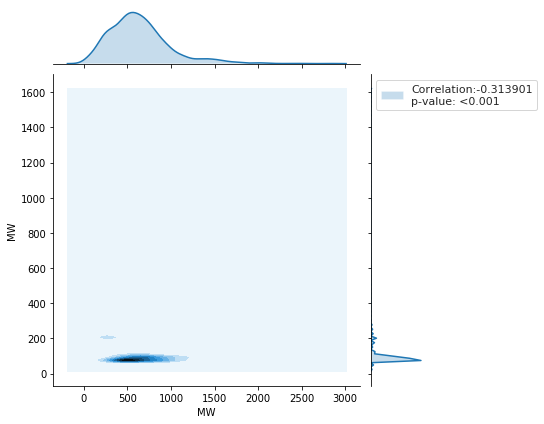

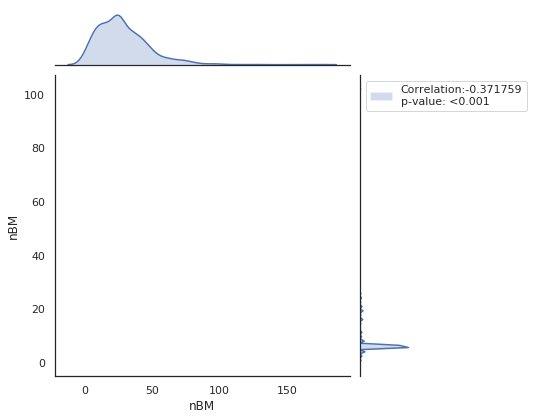

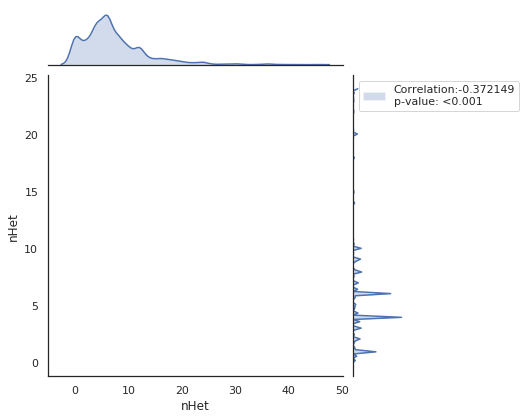

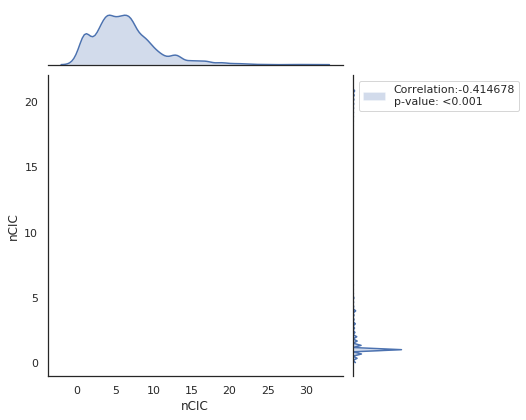

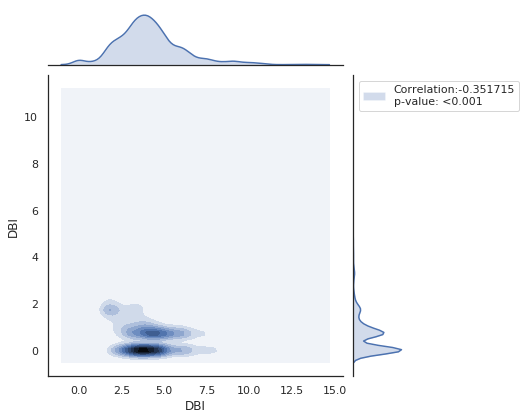

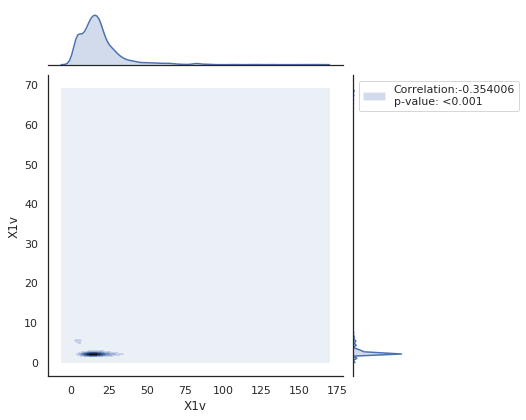

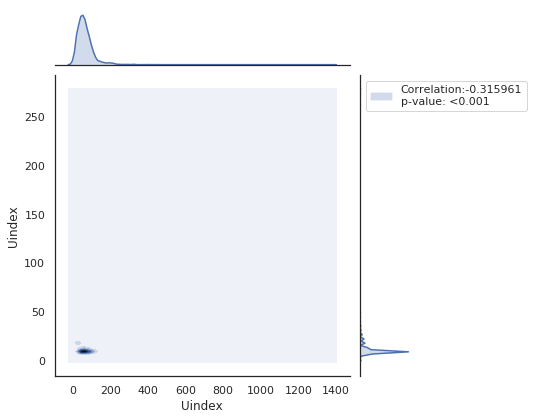

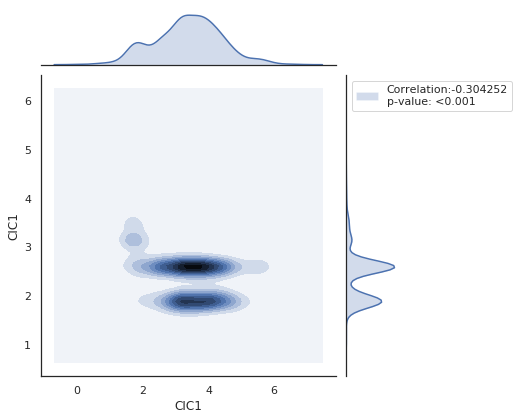

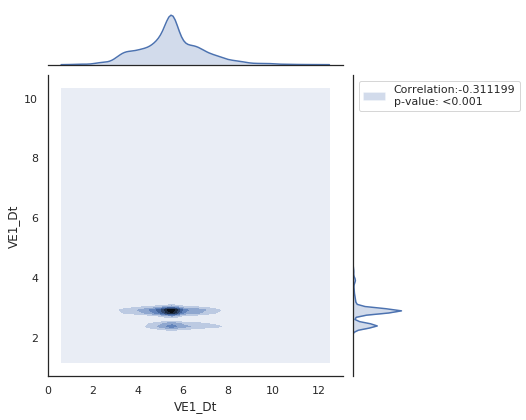

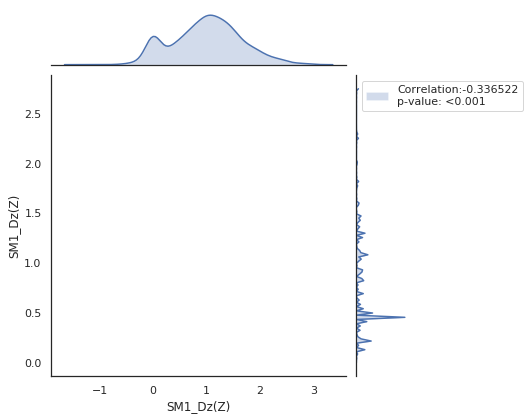

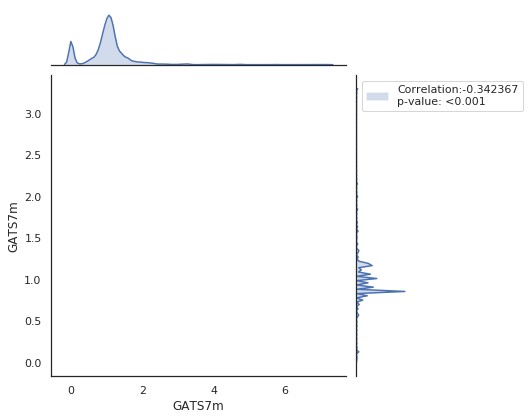

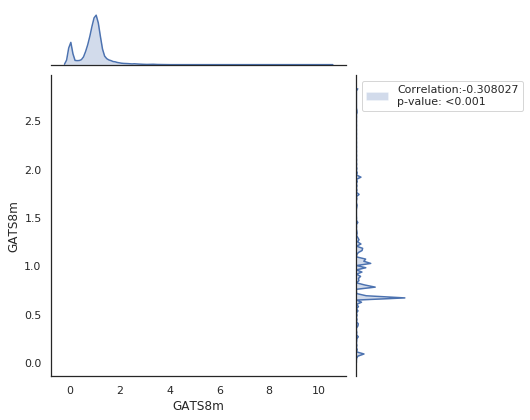

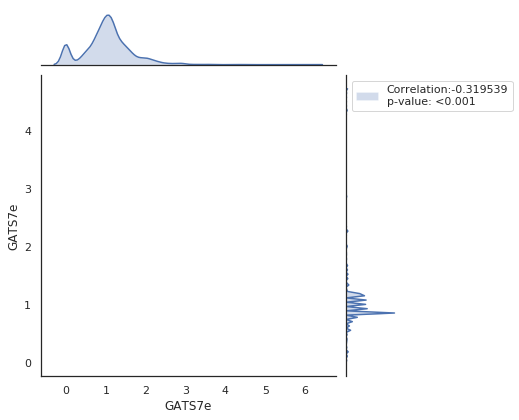

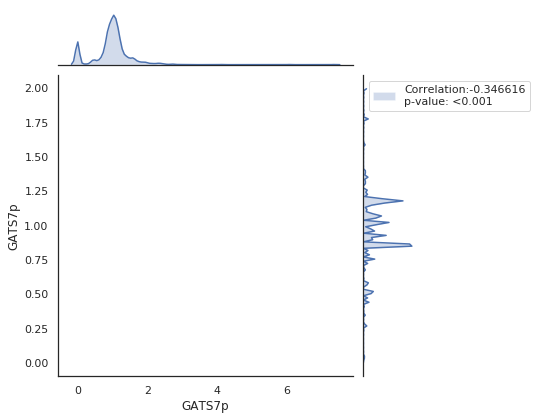

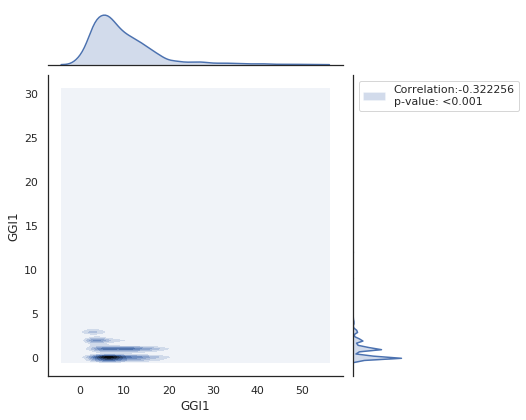

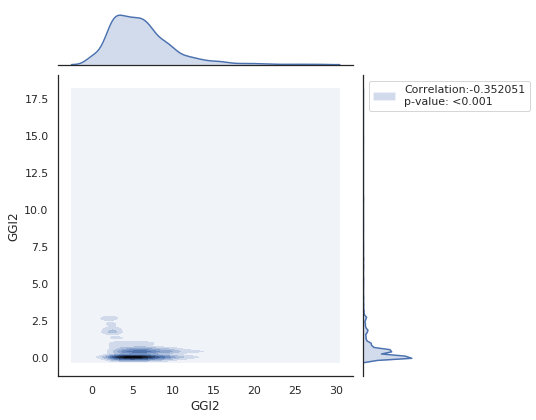

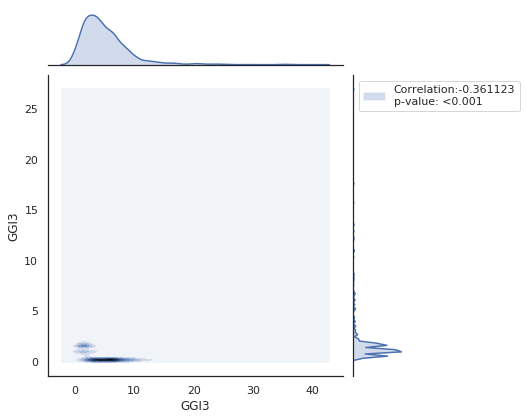

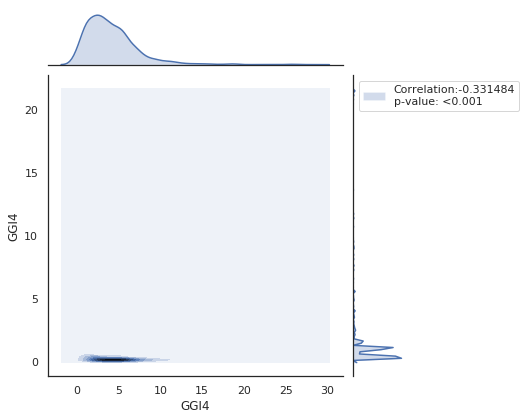

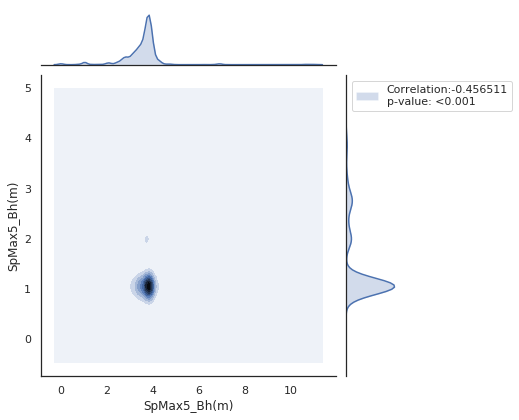

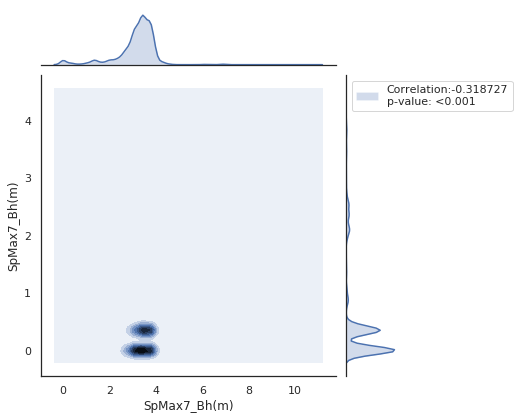

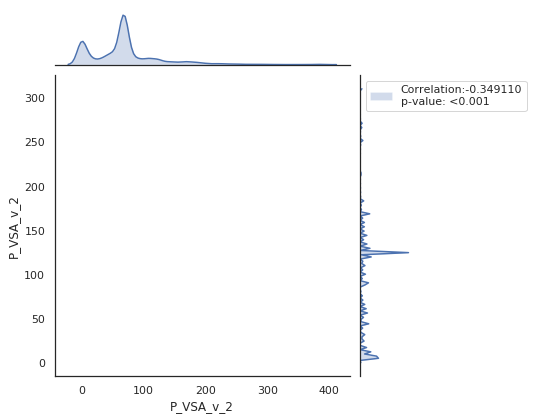

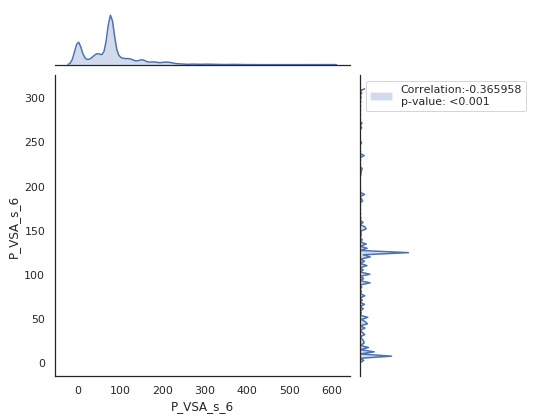

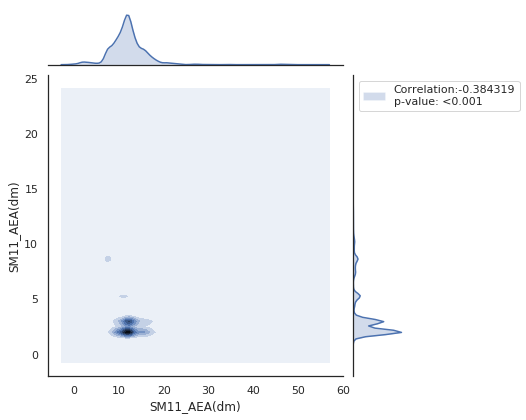

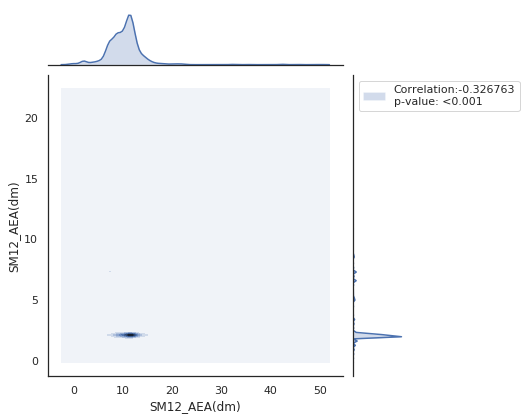

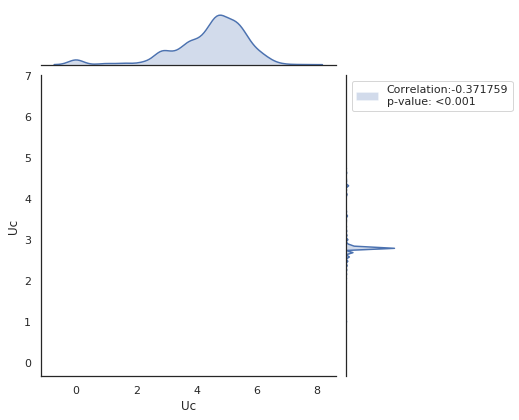

In [22]:
# Construct density plots where the distribution of each pair of descriptors is shown as well the correlation and the p-value
import numpy as np; np.random.seed(1) 
import matplotlib.pyplot as plt
from scipy.stats import kde
from pylab import rcParams
import seaborn as sns


df1_1=df1_1.fillna(df1_1.mean())
df2_2=df2_2.fillna(df2_2.mean())

def scatter_plots(descriptor):
  #plt.figure(figsize=(10,10))
  #sns.set(rc={'figure.figsize':(11, 8)})
  sns.jointplot(df1_1[descriptor], df2_2[descriptor], kind='kde')             
  sns.set(style="white")
  plt.legend(labels=[r'Correlation:%2f'% spearmanr(df1_1[i].values, df2_2[i].values)[0] + "\n" +"p-value: <0.001"])

  
for i in df1_1.columns.values:
  scatter_plots(i)

In [0]:
x=[df1_1[i]**2 for i in df1_1.columns.values]
x=pd.DataFrame(np.transpose(x), columns=df1_1.columns.values)

y=[df2_2[i]**2 for i in df2_2.columns.values]
y=pd.DataFrame(np.transpose(y), columns=df2_2.columns.values)

z=x+y

k=[np.sqrt((z[i])) for i in df1_1.columns.values]
df=pd.DataFrame(np.transpose(k), columns=df2_2.columns.values)

In [49]:
x=[df1_1[i] for i in df1_1.columns.values]
x=pd.DataFrame(np.transpose(x), columns=df1_1.columns.values)

y=[df2_2[i] for i in df2_2.columns.values]
y=pd.DataFrame(np.transpose(y), columns=df2_2.columns.values)

z= (x-y)**2

k=[(z[i]) for i in df1_1.columns.values]
df=pd.DataFrame(np.transpose(k), columns=df2_2.columns.values)
df.head()

,MW,nBM,nHet,nCIC,DBI,X1v,Uindex,CIC1,VE1_Dt,SM1_Dz(Z),GATS7m,GATS8m,GATS7e,GATS7p,GGI1,GGI2,GGI3,GGI4,SpMax5_Bh(m),SpMax7_Bh(m),P_VSA_v_2,P_VSA_s_6,SM11_AEA(dm),SM12_AEA(dm),Uc
0,1.895964e+06,2916.0,576.0,144.0,49.000000,4325.561361,7573.524676,8.934121,30.019441,7.535025,2.676496,1.692601,3.508129,1.585081,702.25,128.436889,173.738761,68.194564,6.441444,12.229009,36.890653,46.535482,100.460529,111.281401,9.759376
1,3.583220e+03,49.0,0.0,1.0,1.000000,0.055696,265.396681,0.509796,0.324900,0.313600,0.994009,1.792921,0.223729,1.605289,9.00,4.937284,3.779136,2.614689,0.105625,3.426201,10116.336400,10116.336400,14.122564,26.142769,2.128681
2,1.959302e+05,784.0,4.0,25.0,16.999129,144.240100,2319.770896,1.194649,2.020855,0.063001,1.040400,1.036324,0.674041,1.140624,36.00,23.902321,9.853321,4.901796,6.036849,11.148921,39.050001,0.000000,67.059721,65.934400,5.391684
3,1.677476e+05,441.0,9.0,16.0,5.508409,117.570649,3098.814889,1.113025,13.126129,0.017956,1.089936,0.810000,1.159929,1.249924,64.00,50.580544,24.176889,15.515721,5.456896,10.297681,8320.541089,7760.200464,112.869376,135.932281,12.418576
4,6.130890e+03,9.0,0.0,4.0,1.030225,22.372900,108.993600,0.224676,0.588289,0.641601,0.863041,0.870489,1.471369,0.373321,0.00,0.790321,0.390625,0.505521,0.141376,0.028561,15434.832169,15434.832169,0.004489,1.755625,0.121104


In [70]:
df = pd.concat([df1_1, df2_2], axis=1)
df.head()

,MW,nBM,nHet,nCIC,DBI,X1v,Uindex,CIC1,VE1_Dt,SM1_Dz(Z),GATS7m,GATS8m,GATS7e,GATS7p,GGI1,GGI2,GGI3,GGI4,SpMax5_Bh(m),SpMax7_Bh(m),P_VSA_v_2,P_VSA_s_6,SM11_AEA(dm),SM12_AEA(dm),Uc,MW,nBM,nHet,nCIC,DBI,X1v,Uindex,CIC1,VE1_Dt,SM1_Dz(Z),GATS7m,GATS8m,GATS7e,GATS7p,GGI1,GGI2,GGI3,GGI4,SpMax5_Bh(m),SpMax7_Bh(m),P_VSA_v_2,P_VSA_s_6,SM11_AEA(dm),SM12_AEA(dm),Uc
0,106.18,6.0,0.0,1.0,1.000,2.827,11.915,1.973,2.397,0.000,0.000,0.000,0.000,0.000,1.5,1.111,0.375,0.222,1.961,0.838,0.000,0.000,3.464,2.938,2.807,1483.12,60.0,24.0,13.0,8.000,68.596,98.941,4.962,7.876000,2.745,1.636,1.301,1.873,1.259,28.0,12.444,13.556,8.480,4.499,4.335,6.073768,6.821692,13.487,13.487,5.931
1,264.24,10.0,4.0,3.0,2.000,5.959,29.658,2.571,3.493,0.693,0.997,1.339,0.473,1.267,4.0,3.111,2.000,1.797,3.043,2.804,100.580,100.580,8.622,7.782,3.459,204.38,3.0,4.0,2.0,1.000,6.195,13.367,1.857,2.923000,1.253,0.000,0.000,0.000,0.000,1.0,0.889,0.056,0.180,2.718,0.953,0.000000,0.000000,4.864,2.669,2.000
2,520.76,34.0,2.0,6.0,4.123,14.010,56.356,3.678,4.303,0.251,1.020,1.018,0.821,1.068,6.0,4.889,3.139,2.214,3.496,3.339,6.249,0.000,10.189,10.120,5.129,78.12,6.0,0.0,1.0,0.000,2.000,8.192,2.585,2.881432,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,1.039,0.000,0.000000,0.000000,2.000,2.000,2.807
3,88.12,1.0,2.0,0.0,2.236,1.904,11.434,1.714,2.235,0.405,0.000,0.000,0.000,0.000,1.5,0.444,0.250,0.000,1.024,0.083,36.145,36.145,1.530,-0.796,1.000,497.69,22.0,5.0,4.0,4.583,12.747,67.101,2.769,5.858000,0.539,1.044,0.900,1.077,1.118,9.5,7.556,5.167,3.939,3.360,3.292,127.362000,124.237000,12.154,10.863,4.524
4,332.56,13.0,4.0,4.0,2.449,10.350,26.023,1.719,3.046,1.253,0.386,0.812,0.487,0.561,4.0,1.778,1.750,1.858,3.312,2.746,0.000,0.000,9.028,6.859,3.807,254.26,10.0,4.0,2.0,3.464,5.620,36.463,2.193,3.813000,0.452,1.315,1.745,1.700,1.172,4.0,2.667,1.125,1.147,2.936,2.915,124.237000,124.237000,8.961,8.184,3.459


In [0]:
# Construct a correlation matrix for each molecular combination
a=df1_1.iloc[0, :]
b=df2_2.iloc[0,: ]
df = pd.concat([a,b])
#c= np.corrcoef([a],[b])

df.head()
#from scipy.spatial.distance import pdist,squareform
#DF_var= 
#
#squareform(pdist(DF_var, metric='euclidean'))

MW      106.18
nBM       6.00
nHet      0.00
nCIC      1.00
DBI       1.00
Name: 0, dtype: float64

In [32]:
dataset[dataset['Z'] > 2] = 0
dataset[dataset['Z'] == 2] = 1
dataset['Z'].shape


(1738,)

In [0]:
# Use deep one classification instead


In [31]:
# Construct the labelled dataset by contatenating the feature set of each coformer
import math
df11_ = np.matrix(df1_1, dtype=float)
df22_ = np.matrix(df2_2, dtype=float)
df = df11_ - df22_



df= pd.DataFrame(df,columns=df1_1.columns.values)


print(df.shape)
df.head()

(1738, 25)


,MW,nBM,nHet,nCIC,DBI,X1v,Uindex,CIC1,VE1_Dt,SM1_Dz(Z),GATS7m,GATS8m,GATS7e,GATS7p,GGI1,GGI2,GGI3,GGI4,SpMax5_Bh(m),SpMax7_Bh(m),P_VSA_v_2,P_VSA_s_6,SM11_AEA(dm),SM12_AEA(dm),Uc
0,-1376.94,-54.0,-24.0,-12.0,-7.000,-65.769,-87.026,-2.989,-5.479000,-2.745,-1.636,-1.301,-1.873,-1.259,-26.5,-11.333,-13.181,-8.258,-2.538,-3.497,-6.073768,-6.821692,-10.023,-10.549,-3.124
1,59.86,7.0,0.0,1.0,1.000,-0.236,16.291,0.714,0.570000,-0.560,0.997,1.339,0.473,1.267,3.0,2.222,1.944,1.617,0.325,1.851,100.580000,100.580000,3.758,5.113,1.459
2,442.64,28.0,2.0,5.0,4.123,12.010,48.164,1.093,1.421568,0.251,1.020,1.018,0.821,1.068,6.0,4.889,3.139,2.214,2.457,3.339,6.249000,0.000000,8.189,8.120,2.322
3,-409.57,-21.0,-3.0,-4.0,-2.347,-10.843,-55.667,-1.055,-3.623000,-0.134,-1.044,-0.900,-1.077,-1.118,-8.0,-7.112,-4.917,-3.939,-2.336,-3.209,-91.217000,-88.092000,-10.624,-11.659,-3.524
4,78.30,3.0,0.0,2.0,-1.015,4.730,-10.440,-0.474,-0.767000,0.801,-0.929,-0.933,-1.213,-0.611,0.0,-0.889,0.625,0.711,0.376,-0.169,-124.237000,-124.237000,0.067,-1.325,0.348


In [0]:
# Standarize the dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

X= df.iloc[:, :].values
y=dataset['Z'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)

In [75]:


from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid', degree=10)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 43  59]
 [ 75 171]]
              precision    recall  f1-score   support

           0       0.36      0.42      0.39       102
           1       0.74      0.70      0.72       246

    accuracy                           0.61       348
   macro avg       0.55      0.56      0.55       348
weighted avg       0.63      0.61      0.62       348



In [73]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 42  60]
 [ 84 162]]
              precision    recall  f1-score   support

           0       0.33      0.41      0.37       102
           1       0.73      0.66      0.69       246

    accuracy                           0.59       348
   macro avg       0.53      0.54      0.53       348
weighted avg       0.61      0.59      0.60       348



In [74]:
import xgboost as xgb
clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=5000, nthread=6, max_depth=20, seed=0, silent=True,
							subsample=0.85, colsample_bytree=0.85)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 37  65]
 [ 61 185]]
              precision    recall  f1-score   support

           0       0.38      0.36      0.37       102
           1       0.74      0.75      0.75       246

    accuracy                           0.64       348
   macro avg       0.56      0.56      0.56       348
weighted avg       0.63      0.64      0.64       348



In [86]:
# Import the unlabeled data

link='https://drive.google.com/open?id=1KuMMcCStCrvXCw4JmYvQ5GrtuPlQ-NQB'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('unlabelled_dragon.csv') 


# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('unlabelled_dragon.csv')



val = unlabeled['NAME'].values
length = len(val)
print(length)
unlabeled=unlabeled.loc[:, (unlabeled != 0).any(axis=0)]

1KuMMcCStCrvXCw4JmYvQ5GrtuPlQ-NQB
209


In [87]:
pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

pairs = pd.DataFrame(pairs)
keys = unlabeled['NAME'].values
values = unlabeled.iloc[:, 1:].values

d = {key:value for key, value in zip(keys, values)}
print(len(d['ZINC000000354958']))

2009


In [0]:
mol1_data= list()

for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 1:].columns.values)   


In [0]:
mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 1:].columns.values)   

In [0]:
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(final_1.mean())
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(final_2.mean())

In [83]:
unlab=pd.concat([pairs[0], pairs[1]], axis=1)
unlab.shape

(21736, 2)

In [0]:
print(final_1.shape)
print(final_2.shape)

final_1 = final_1.replace({'#NUM!': 0})
final_2 = final_2.replace({'#NUM!': 0})

final_11=final_1[df.columns.values]
final_22=final_2[df.columns.values]

print(final_11.shape)
print(final_22.shape)

(21736, 2010)
(21736, 2010)
(21736, 25)
(21736, 25)


In [0]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)

uf_tot=pd.concat([pd.DataFrame(comb, columns=['comb']),final_11, final_22 ], axis=1)

keys1 = uf_tot['comb'].values
values1 =  uf_tot.iloc[:, 1:].values

dii={key:value for key, value in zip(keys1, values1)}


In [77]:
# Construct the unlabelled dataset likewise the labelled dataset
uf1=final_11
uf2=final_22
uf11 = np.matrix(uf1, dtype=float)
uf22 = np.matrix(uf2, dtype=float)
#uf = uf11-uf22 


#uf= pd.DataFrame(uf, columns=uf1.columns.values)
#uf.head()

#uf.shape

NameError: ignored

In [76]:
uf = pd.concat([uf1, uf2], axis=1)


NameError: ignored

In [0]:
x=[uf1[i] for i in uf1.columns.values]
x=pd.DataFrame(np.transpose(x), columns=uf1.columns.values)

y=[uf2[i] for i in uf2.columns.values]
y=pd.DataFrame(np.transpose(y), columns=uf2.columns.values)

z= (x-y)**2

k=[(z[i]) for i in uf1.columns.values]
uf=pd.DataFrame(np.transpose(k), columns=uf2.columns.values)
uf.head()

,MW,nBM,nHet,nCIC,DBI,X1v,Uindex,CIC1,VE1_Dt,SM1_Dz(Z),GATS7m,GATS8m,GATS7e,GATS7p,GGI1,GGI2,GGI3,GGI4,SpMax5_Bh(m),SpMax7_Bh(m),P_VSA_v_2,P_VSA_s_6,SM11_AEA(dm),SM12_AEA(dm),Uc
0,35.5216,49.0,4.0,1.0,0.000000,0.258064,3.873024,1.329409,0.998001,0.164025,0.020449,3.651921,0.940900,0.205209,1.00,0.444889,0.130321,0.161604,0.022801,0.088804,2529.0841,2529.0841,0.021904,1.147041,0.274576
1,403.2064,81.0,4.0,1.0,0.000000,1.380625,0.986049,1.855044,0.662596,0.164025,0.052900,1.102500,1.117249,0.133956,1.00,0.198025,0.015625,0.020164,0.010000,0.001369,2529.0841,2529.0841,0.003481,2.782224,0.414736
2,1944.8100,144.0,4.0,4.0,0.055696,3.682561,4.473225,2.047761,1.737124,0.164025,0.002916,0.719104,0.776161,0.293764,0.25,0.049729,0.015625,0.421201,0.097344,0.004761,2529.0841,2529.0841,0.851929,4.695889,0.651249
3,4640.3344,225.0,4.0,9.0,0.201601,7.091569,10.784656,2.274064,1.779556,0.164025,0.021025,0.436921,0.465124,0.549081,0.00,0.000000,0.000000,1.155625,0.168921,0.025600,2529.0841,2529.0841,1.313316,9.897316,0.910116
4,6406.4016,9.0,4.0,1.0,0.343396,2.729104,58.967041,0.039204,0.044521,0.164025,2.090916,3.651921,5.166529,0.722500,2.25,1.779556,0.426409,1.640961,0.279841,1.442401,2529.0841,2529.0841,10.368400,2.359296,0.090000


In [0]:
x=[uf1[i]**2 for i in uf1.columns.values]
x=pd.DataFrame(np.transpose(x), columns=uf1.columns.values)

y=[uf2[i]**2 for i in uf2.columns.values]
y=pd.DataFrame(np.transpose(y), columns=uf2.columns.values)

z=x+y

k=[np.sqrt((z[i])) for i in uf1.columns.values]
uf=pd.DataFrame(np.transpose(k), columns=uf2.columns.values)

In [0]:
# Check if any of the entries at the unlabeled dataset already exist in the labeled dataset and remove them (from the unlabeled dataset)
# Consider of using this structures as a validation point to check if they are found in the top percent of the predicted ones (consider the score too)

df_tot=pd.concat([pd.DataFrame(dataset['Identifier'].values, columns=['comb']),df], axis=1)
uf_tota=pd.concat([pd.DataFrame(comb, columns=['comb']), uf],axis=1) 

check=pd.concat([df_tot, uf_tota], axis=0)
check.shape
print(check.shape)

c=check.drop_duplicates(subset=check.columns.values[1:] ,keep='first', inplace=False)
print(c.shape)


df1=c.iloc[:1738, :]
uf1=c.iloc[1738:, :]
print(uf1.shape)
print(df1.shape)


val = pd.concat([uf_tota, uf1], axis=0)
v= val['comb'].drop_duplicates(keep=False, inplace=False)
df=df1.iloc[:, 1:]
uf=uf1.iloc[:, 1:]

(23474, 26)
(23060, 26)
(21322, 26)
(1738, 26)


In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#X_scaler = StandardScaler()
X_scaler = MinMaxScaler()
numerical_cols = df.columns[:]

df_scaled = pd.DataFrame(X_scaler.fit_transform(df[numerical_cols]), columns=numerical_cols, index=df.index)
df_scaled=df_scaled.fillna(df_scaled.mean())
df_scaled.head()



uf=uf.fillna(uf.mean())
uf_scaled = pd.DataFrame(X_scaler.transform(uf[numerical_cols]), columns=numerical_cols, index=uf.index)
uf_scaled=uf_scaled.fillna(uf_scaled.mean())
uf_scaled.head()



,MW,nBM,nHet,nCIC,DBI,X1v,Uindex,CIC1,VE1_Dt,SM1_Dz(Z),GATS7m,GATS8m,GATS7e,GATS7p,GGI1,GGI2,GGI3,GGI4,SpMax5_Bh(m),SpMax7_Bh(m),P_VSA_v_2,P_VSA_s_6,SM11_AEA(dm),SM12_AEA(dm),Uc
0,0.000005,0.001736,0.001975,0.001111,0.000000,0.000010,2.062937e-06,0.075905,0.012918,0.019119,0.000399,0.034150,0.024974,0.003815,0.0004,0.000567,0.000079,0.000201,0.000226,0.000762,0.016642,0.007334,0.000009,0.000524,0.005621
1,0.000055,0.002870,0.001975,0.001111,0.000000,0.000053,5.252117e-07,0.105916,0.008577,0.019119,0.001032,0.010310,0.029655,0.002490,0.0004,0.000253,0.000010,0.000025,0.000098,0.000012,0.016642,0.007334,0.000001,0.001270,0.008491
2,0.000265,0.005102,0.001975,0.004444,0.000299,0.000141,2.382630e-06,0.116920,0.022485,0.019119,0.000057,0.006725,0.020601,0.005462,0.0001,0.000063,0.000010,0.000524,0.000967,0.000041,0.016642,0.007334,0.000332,0.002143,0.013333
3,0.000632,0.007972,0.001975,0.010000,0.001084,0.000272,5.744367e-06,0.129841,0.023034,0.019119,0.000410,0.004086,0.012346,0.010208,0.0000,0.000000,0.000000,0.001438,0.001679,0.000220,0.016642,0.007334,0.000511,0.004517,0.018632
4,0.000872,0.000319,0.001975,0.001111,0.001846,0.000105,3.140836e-05,0.002238,0.000576,0.019119,0.040775,0.034150,0.137134,0.013432,0.0009,0.002270,0.000260,0.002042,0.002782,0.012382,0.016642,0.007334,0.004035,0.001077,0.001843


In [0]:
from sklearn.decomposition import PCA

df_scaled.iloc[:,:].values
#ul_scaled.iloc[:,:].values
pca = PCA(n_components=3)
pc_df= pca.fit_transform(df_scaled)
pc_uf= pca.transform(uf_scaled)

#principalDf = pd.DataFrame(data = pc_df
#             , columns = ['principal component 1', 'principal component 2'])


['42.97%', '15.67%', '6.84%']


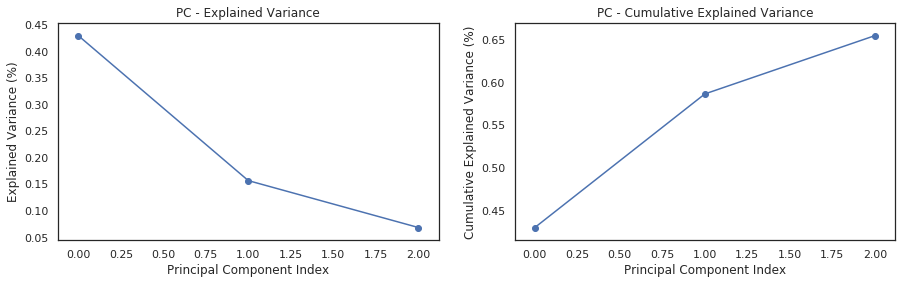

In [0]:
sk_expl_var = np.round(pca.explained_variance_ratio_ * 100, 2)
print([f'{re}%' for re in sk_expl_var])


import matplotlib.pyplot as plt

def plot_explained_variance(pca_explained_variance_ratio_):
    fig, ax = plt.subplots(1,2,figsize=[15,4])

    ax[0].plot(pca_explained_variance_ratio_)
    ax[0].scatter(range(len(pca_explained_variance_ratio_)), pca_explained_variance_ratio_)
    ax[0].set_title('PC - Explained Variance')
    ax[0].set_xlabel('Principal Component Index')
    ax[0].set_ylabel('Explained Variance (%)');

    accumulative_expl_var = []
    for i in range(len(pca_explained_variance_ratio_)):
        accumulative_expl_var.append(np.sum(pca_explained_variance_ratio_[:i+1]))
    ax[1].plot(accumulative_expl_var)
    ax[1].scatter(range(len(accumulative_expl_var)), accumulative_expl_var)
    ax[1].set_title('PC - Cumulative Explained Variance')
    ax[1].set_xlabel('Principal Component Index')
    ax[1].set_ylabel('Cumulative Explained Variance (%)'); 
    
plot_explained_variance(pca.explained_variance_ratio_)


In [0]:
link='https://drive.google.com/open?id=1aFDHKC1GWMathjOYT0bP6wUMXKOOYeav'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dict_unlab.csv') 
dictionary = pd.read_csv('dict_unlab.csv')

keys = dictionary['comb'].values
values = dictionary.iloc[:, 1:-2].values

dict = {key:value for key, value in zip(keys, values)}
print(dict['comb10661'])

dictionary.head()

1aFDHKC1GWMathjOYT0bP6wUMXKOOYeav
['c1ccc2c(c1)ccc3c4ccccc4sc23' 'C1c2ccccc2c3c1ccc4ccccc34']


,comb,smiles1,smiles2,mol1,mol2
0,comb1,O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34,c1cc2c3cccc4ccc5ccc(c1)c2c5c34,ZINC000000354958,ZINC000001570229
1,comb2,O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34,c1ccc2c(c1)c3cccc4ccc5cccc2c5c34,ZINC000000354958,ZINC000001570230
2,comb3,O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,ZINC000000354958,ZINC000001570232
3,comb4,O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34,c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27,ZINC000000354958,ZINC000001580987
4,comb5,O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34,C1=Cc2cccc3cccc1c23,ZINC000000354958,ZINC000001689804


In [0]:
#Install the pyod library
!git clone https://github.com/yzhao062/pyod.git
%cd pyod
!pip install .

Cloning into 'pyod'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 5856 (delta 76), reused 89 (delta 45), pack-reused 5721
Receiving objects: 100% (5856/5856), 35.24 MiB | 22.36 MiB/s, done.
Resolving deltas: 100% (4043/4043), done.
/content/pyod
Processing /content/pyod
  Created wheel for pyod: filename=pyod-0.7.4-cp36-none-any.whl size=153605 sha256=9cd7a023791ca09598dc981e539d95463c76a84f9e9c9569bcc45a1ed0e5683a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7fj7r5uo/wheels/e9/f5/0e/d4503681e4cf321c8fcc6a71c0bacc4880ce0d428d14540070
Successfully built pyod


In [0]:
# Install the RDKit library
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# Append rdkit path to current python system path
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')



--2019-10-03 16:47:43--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75257002 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  71.77M   216MB/s    in 0.3s    

2019-10-03 16:47:44 (216 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [75257002/75257002]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==0.24.0=py37_0
    - bzip2==1.0.8=h7b6447c_0
    - ca-certificates==2019.5.15=0
    - certifi==2019.6.16=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1
    - conda-package-ha

In [0]:
# import rdkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [0]:
# Define a function for getting the average of a list 
# Is used for calculating the average cross validation, which is used for hyperparameters optimization
def Average(lst):
  return sum(lst)/len(lst)

In [0]:
# Define a function whereby the top-ranked 25% of the unlabeled dataset will be selected
def construct_list(clf):
  clf.fit(X_train)
  prob=clf.decision_function(X_test) * -1
  prob = pd.DataFrame(prob, columns =['test_score'])
  proba = pd.concat([dictionary['comb'], prob], axis=1, ignore_index= False)
  c=pd.DataFrame(proba.describe().loc['75%'].astype(float)).iloc[0].values[0]
  proba_ = proba.sort_values(by = ['test_score'], ascending=True)
  b = proba[proba['test_score']> c]

  return b 

In [0]:
# Define a function to remove duplicates

def Remove(duplicate):
  seen = set()
  result = []
  for item in duplicate:
    if item not in seen:
        seen.add(item)
        result.append(item)
        
  return result

In [0]:
# Keep only the combinations where at least one of the molecules is one of the initials molecules (excluding fullerene as we are not interested at that point to synthesize that type of cocrystals)

initial_molecules=['c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1',                 # pentacene
                   'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34',               # picene
                   'c1ccc2c3ccccc3c4ccccc4c2c1',                       # triphenylene
                   'c1ccc2c(c1)ccc3ccccc23',                           # phenanthrene
                   'c1ccc2c(c1)c3cccc4cccc2c34',                       # fluoranthene
                   'c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27',           #coronene
                   'c1ccc2c(c1)ccc1cc3cc4cc5c(ccc6ccccc65)cc4cc3cc12', #dibenzo-pentacene
                   'c1cc2ccc3ccc4ccc5ccc1c1c2c3c4c51',                 #corannulene
                  'c1ccc2c(c1)ccc3ccc4ccc5ccc6ccc7ccc8ccccc8c7c6c5c4c23'] #octaelicene
                   

def final_list(b):
  lista=[]
  lista1=[]
  for k in initial_molecules:
    for x in b['comb']:
      for i in range(0,2):
        if k in dict[x][i]:
          lista1.append(x)
  return Remove(lista1)         

In [0]:
# Hyperopt library if we want to find the best parameters of the implemented algorithms to achieve the highest average k-fold cross validation

import lightgbm as lgb
from hyperopt import STATUS_OK
from sklearn.model_selection import KFold

# Create the dataset
X_train=df_scaled


# Import the classifier
from pyod.models.abod import ABOD


# Perform k-fold cross validation
from sklearn.model_selection import KFold

metric=[]

def objective(params):
  n_neighbors, contamination = int(params['n_neighbors']), params['contamination']
  X_train_val=pd.concat([pd.DataFrame(X_train), pd.DataFrame(np.zeros(len(X_train)))], axis=1)
  kf = KFold(n_splits =5)
  kf.get_n_splits(X_train_val)
  
  model = ABOD(contamination=contamination, n_neighbors=n_neighbors)
          #KNN(contamination=contamination, n_neighbors=n_neighbours)
  
  
  for train, test in kf.split(X_train_val):
    train_data = np.array(X_train_val)[train]
    train_label = train_data[:,-1]
    test_data = np.array(X_train_val)[test]
    test_label = test_data[:, -1]
    model.fit(train_data)
    pred_train = model.predict(train_data)
    pred_test = model.predict(test_data)
    metric.append(metrics.accuracy_score(pred_test, test_label))
    
    best_score = Average(metric)
    loss=1-best_score
  return {'loss':loss, 'status':STATUS_OK}


from hyperopt import hp
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
learning_rate={'learning_rate':hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

space= {
    'contamination': hp.quniform('contamination', 0.01, 0.2, 0.01),
    'n_neighbors':hp.quniform('n_neighbors', 5, 20, 1)
    
}


from hyperopt import tpe

tpe_algorithm=tpe.suggest

from hyperopt import Trials
bayes_trials =Trials()

from hyperopt import fmin

MAX_EVALS=200

#abod_best= fmin(objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS) #, trials= bayes_trials
#print(abod_best)

In [0]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder

# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=0.06),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=25), contamination=0.06),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.06),
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.06),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, n_neighbors=10, method='mean'),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=25, contamination=0.06),
    'One class SVM (OCSVM)': OCSVM(nu=0.089, degree=8, kernel='rbf', gamma=0.99, contamination=0.06),
    #'Autoencoder': AutoEncoder(hidden_neurons=[25, 15,15,25], contamination=0.06)

}

In [0]:
# Fit the classifiers to the train_set to define the learning bounbary where the mojority of the known data lie in
# Then rank the test set combinations based on the learning 
# 

X_train=df_scaled
X_test=uf_scaled
dct = {}
for i, (clf_name, clf) in enumerate(classifiers.items()):
  dct['lst_%s' % i] = []
  dct['lst_%s' % i].append(construct_list(clf))


In [0]:
abod=[]
knn=[]
hbos=[]
feat_bag=[]
ifor=[]
ocsvm=[]
lof=[]
autoencoder=[]

# Define the list that contain the top 25% of the predictions of each algorithm
for i in pd.DataFrame(dct['lst_0'][0])['comb']:
  abod.append(i)
for i in pd.DataFrame(dct['lst_1'][0])['comb']:
  feat_bag.append(i)
for i in pd.DataFrame(dct['lst_2'][0])['comb']:
  hbos.append(i)
for i in pd.DataFrame(dct['lst_3'][0])['comb']:
  ifor.append(i)
for i in pd.DataFrame(dct['lst_4'][0])['comb']:
  knn.append(i)
for i in pd.DataFrame(dct['lst_5'][0])['comb']:
  lof.append(i)
for i in pd.DataFrame(dct['lst_6'][0])['comb']:
  ocsvm.append(i)
#for i in pd.DataFrame(dct['lst_7'][0])['comb']:
 # autoencoder.append(i)


In [0]:
# Keep on each list only the 
abod_f=final_list(pd.DataFrame(abod, columns=['comb']))
feat_bag_f=final_list(pd.DataFrame(feat_bag, columns=['comb']))
hbos_f=final_list(pd.DataFrame(hbos, columns=['comb']))
ifor_f=final_list(pd.DataFrame(ifor, columns=['comb']))
knn_f=final_list(pd.DataFrame(knn, columns=['comb']))
lof_f=final_list(pd.DataFrame(lof, columns=['comb']))
ocsvm_f=final_list(pd.DataFrame(ocsvm, columns=['comb']))
#autoencoder_f=final_list(pd.DataFrame(autoencoder, columns=['comb']))

In [0]:
# Define a dictionary to connect the 'comb' numbers with the combination of their smiles 
dictionary["combination"] = dictionary["smiles1"].map(str) + dictionary["smiles2"]
ke= dictionary['combination']
v=dictionary['comb']
my_dict= {key:value for key, value in zip(ke, v)}

In [0]:
# Remove equivalent pais of smiles
listaki=[]
for i in lof_f:
  listaki.append(dict[i])
data = {tuple(sorted(item)) for item in listaki}


# Now having the smiles, after removing the equivalent pairs (x,y)=(y,x), we connect them to their 'comb' number
c=pd.DataFrame(data)['combin']=pd.DataFrame(data)[0].map(str) + pd.DataFrame(data)[1]
d=[]
for i in c:
  d.append(my_dict[i])

In [0]:
# Measure the correlations among the predicted combinations
ufa=[]

#for i in Remove(d):
for i in merged1:
  
  ufa.append(dii[i])
  
ufa=pd.DataFrame(ufa, columns=uf_tot.columns.values[1:])
uf1=ufa.iloc[:, :25]
uf2=ufa.iloc[:, 25:]



In [0]:

cor_unl = uf1.corrwith(uf2, axis=0, drop=False, method='spearman').abs()
print(cor_unl.shape)
print(pd.DataFrame(cor_unl.sort_values(ascending=False)))

corr_unl=cor_unl.sort_values(ascending=False)

(25,)
                     0
SM1_Dz(Z)     0.041480
nHet          0.040877
SM11_AEA(dm)  0.036879
nCIC          0.034145
GGI4          0.027575
P_VSA_s_6     0.025146
CIC1          0.024078
GGI2          0.020364
P_VSA_v_2     0.019825
Uc            0.019615
nBM           0.019615
SpMax5_Bh(m)  0.016763
SM12_AEA(dm)  0.015335
X1v           0.013949
GGI3          0.013429
SpMax7_Bh(m)  0.011869
GGI1          0.007970
GATS8m        0.005736
DBI           0.004420
VE1_Dt        0.003813
GATS7e        0.003592
GATS7p        0.003298
GATS7m        0.002121
MW            0.001468
Uindex        0.000272


In [0]:
# Construct a list with all the combinations that have at least one of the initial molecules 
import itertools
merged1=[]
merge1 = itertools.chain(abod_f, hbos_f, ifor_f, feat_bag_f, lof_f,  knn_f, ocsvm_f)#, autoencoder_f)

merged=[]
for i in merge1:
  merged.append(i)
len(merged)

3423

In [0]:
# List with all the top 25% predictions of all the algorthms
import itertools
merged1=[]
merge1 = itertools.chain(abod, hbos, ifor, feat_bag, lof,  knn, ocsvm)#, autoencoder)

merged1=[]
for i in merge1:
  merged1.append(i)
len(merged1)

31986

In [0]:
# Score the combinations that are detected by the most of the algorithms as good ones

combi=[(x, merged.count(x)) for x in set(merged)]
combi=pd.DataFrame(combi, columns=['comb','counts'])
top=combi.loc[combi['counts']>=3]      # If combi['counts']==8, means that the combination is predicted from all the algorithms

topi=top['comb'].values
len(topi)

340

In [0]:
both=[]
for x in topi:
 
  if dict[x][0] in initial_molecules:
        
    if dict[x][1] in initial_molecules:
      #print(x)
      both.append(x)
len(both)
      

4

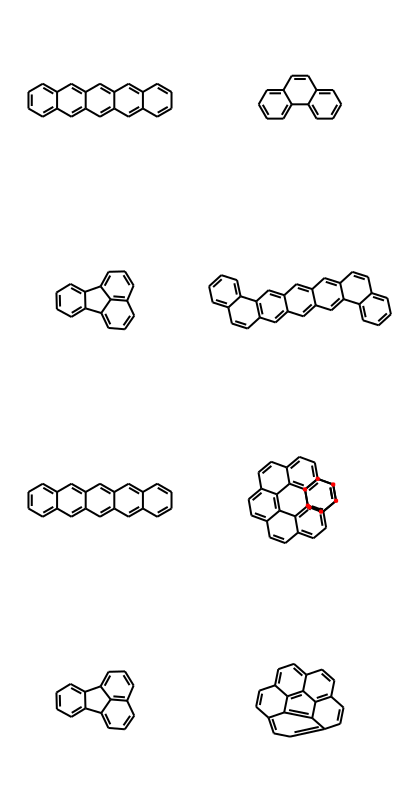

In [0]:
# Visualiza the predicted pairs ising RDKit library

listaki=[]
for i in both:
  #print(topi)
  listaki.append(dict[i])

 
    
aris=np.array(listaki)
aris=aris.tolist()
aris
import itertools

merged = list(itertools.chain(*aris))

aas = [Chem.MolFromSmiles(x) for x in merged]
Draw.MolsToGridImage(aas, molsPerRow=2, useSVG=False)
  
  

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


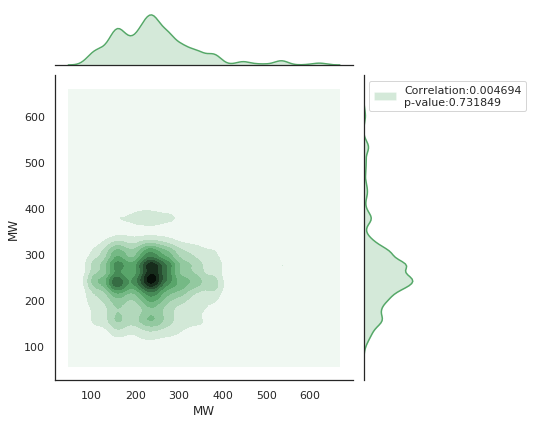

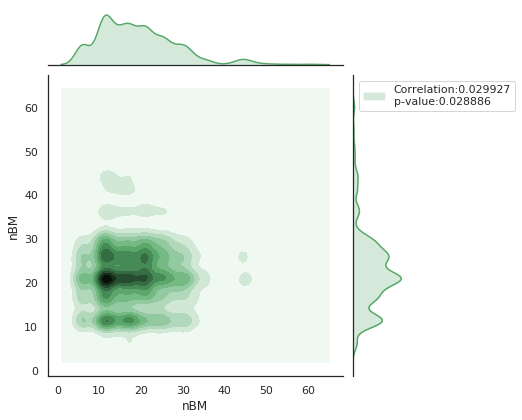

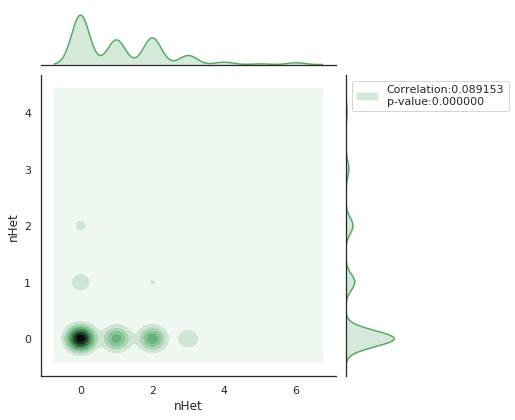

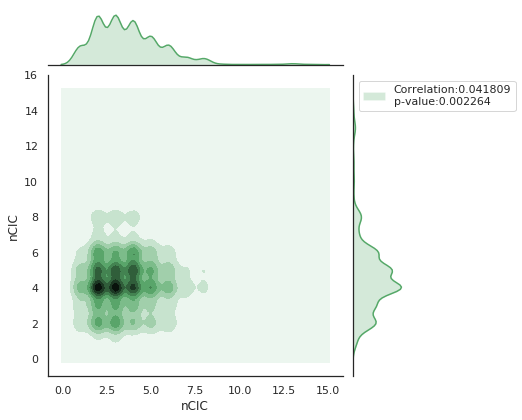

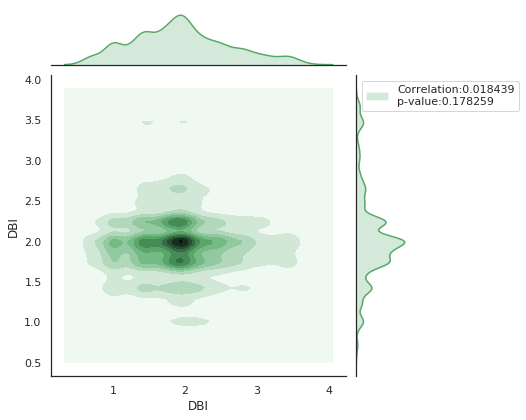

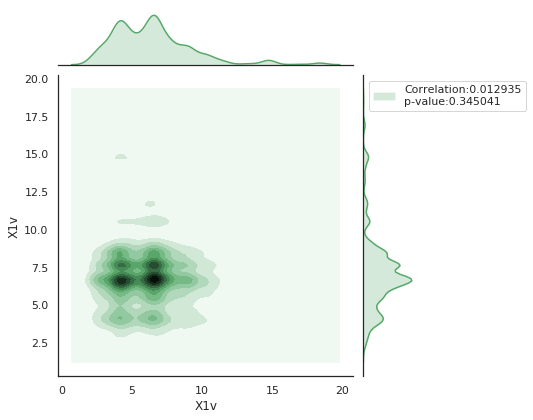

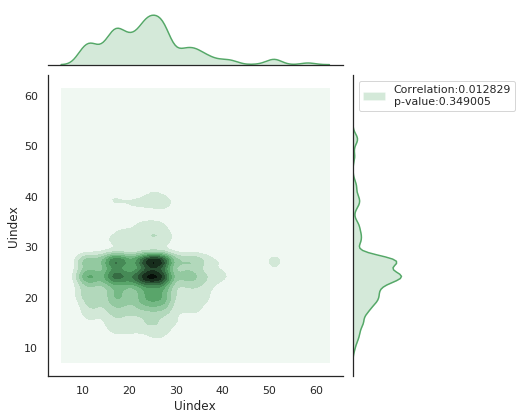

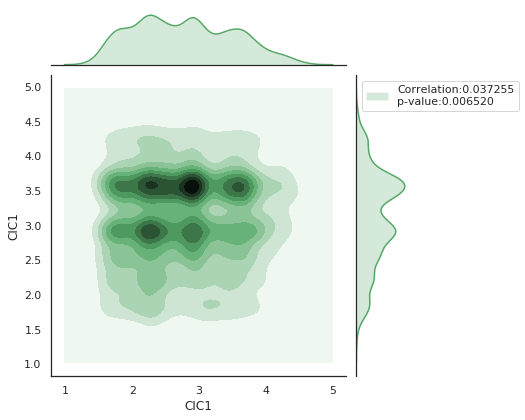

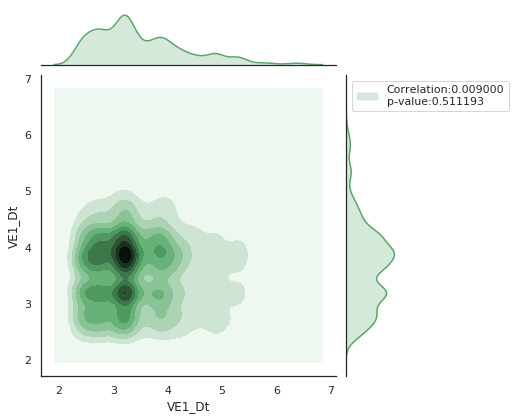

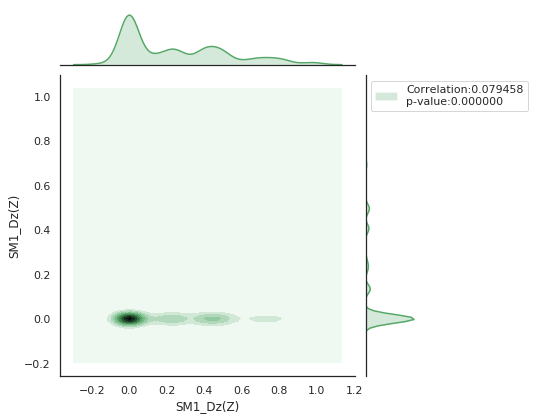

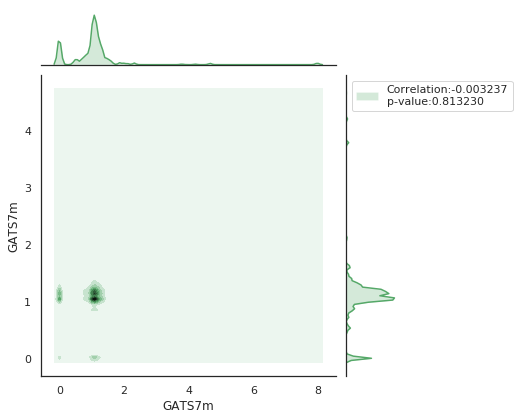

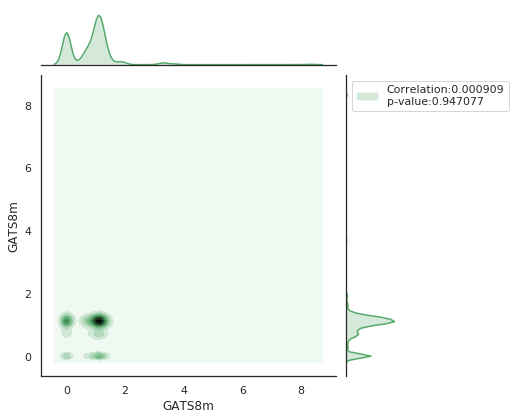

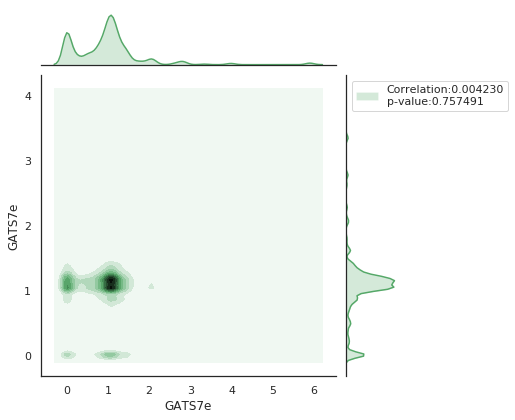

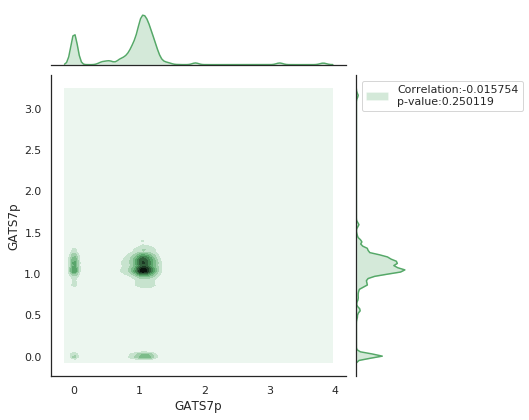

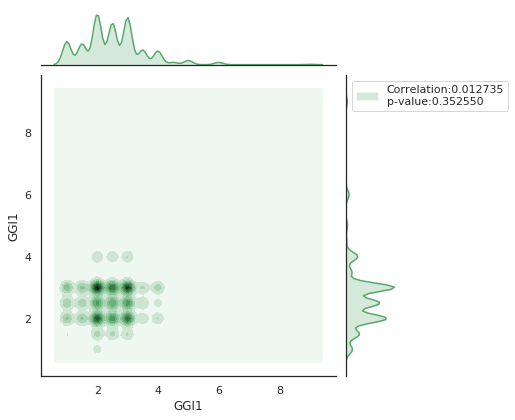

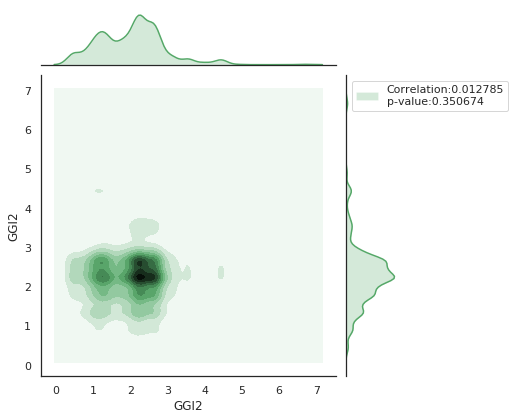

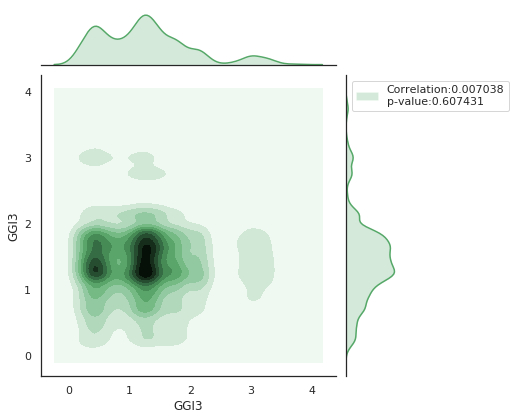

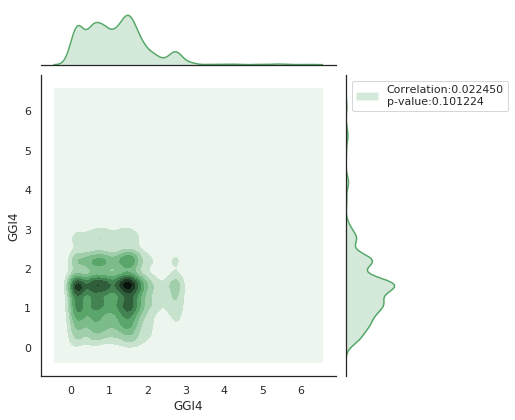

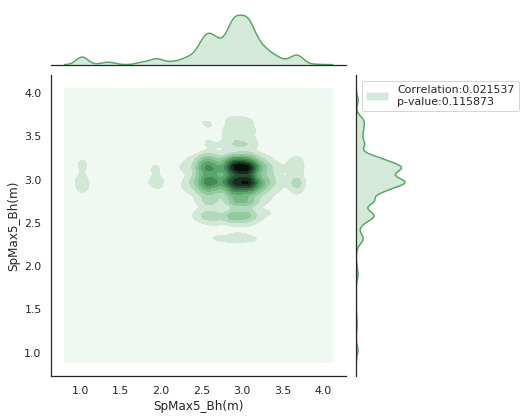

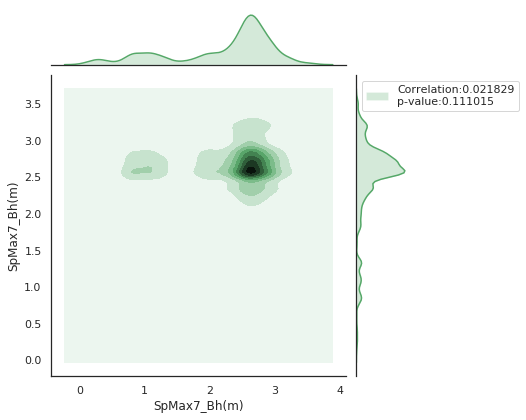

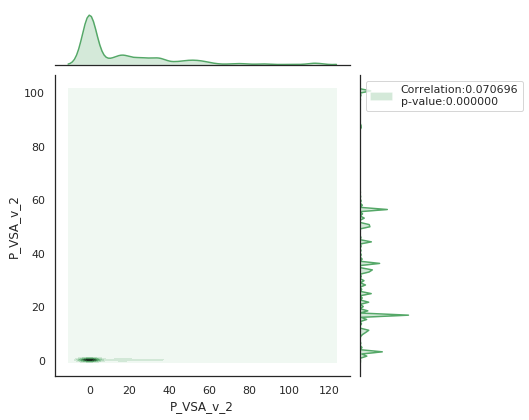

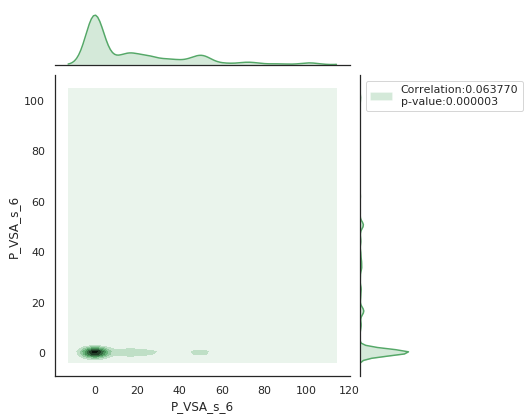

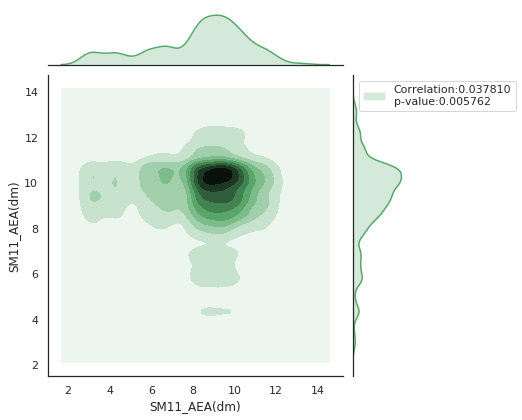

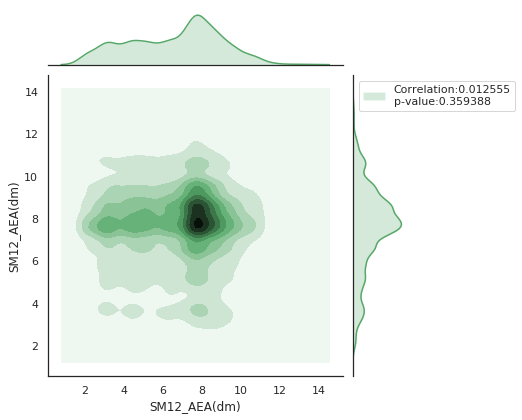

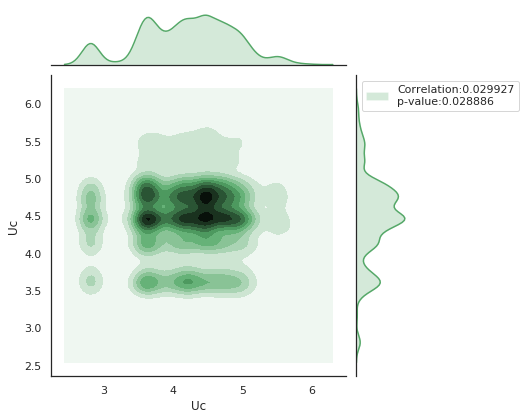

In [0]:
import numpy as np; np.random.seed(1) 
import matplotlib.pyplot as plt
from scipy.stats import kde
from pylab import rcParams
import seaborn as sns



def scatter_plots(descriptor):
  sns.jointplot(uf2[descriptor], uf1[descriptor], kind='kde', color='g')             
  sns.set(style="white")
  plt.legend(labels=[r'Correlation:%2f'% spearmanr(uf1[descriptor].values, uf2[descriptor].values)[0] + "\n" +"p-value:%2f" % spearmanr(uf1[descriptor].values, uf2[descriptor].values)[1]])


for i in uf1.columns.values:
  scatter_plots(i)

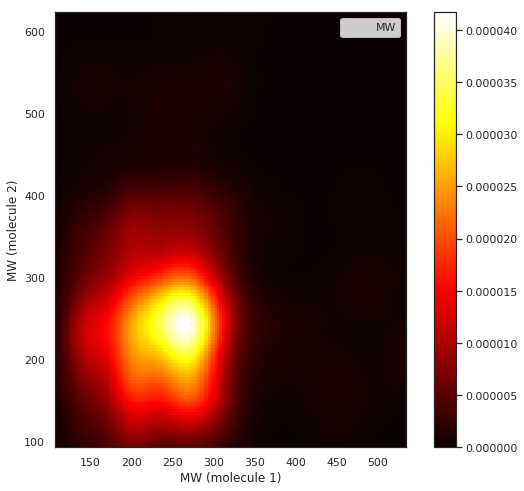

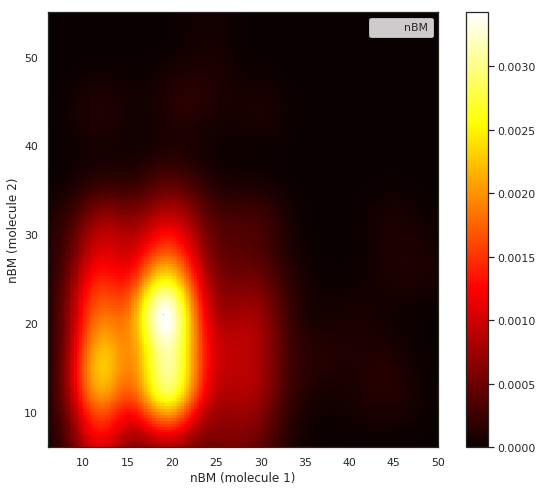

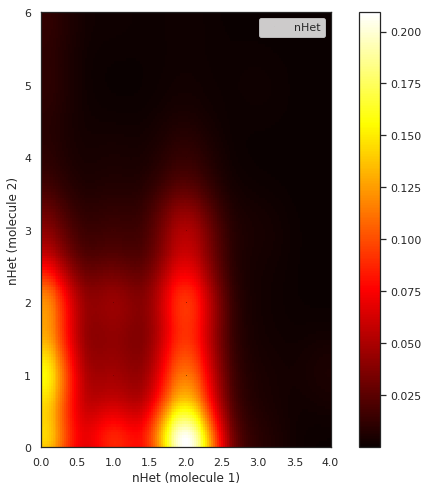

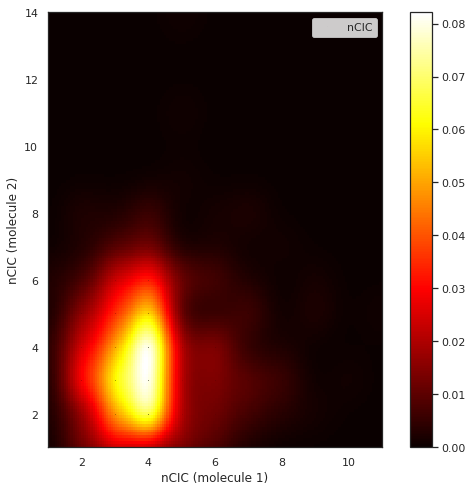

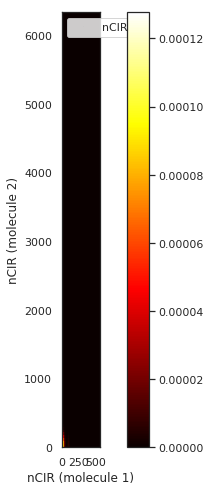

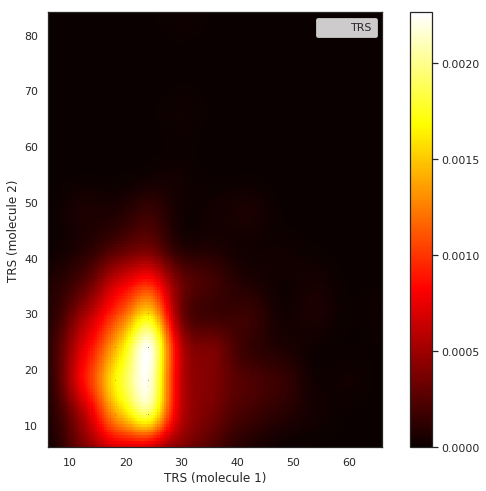

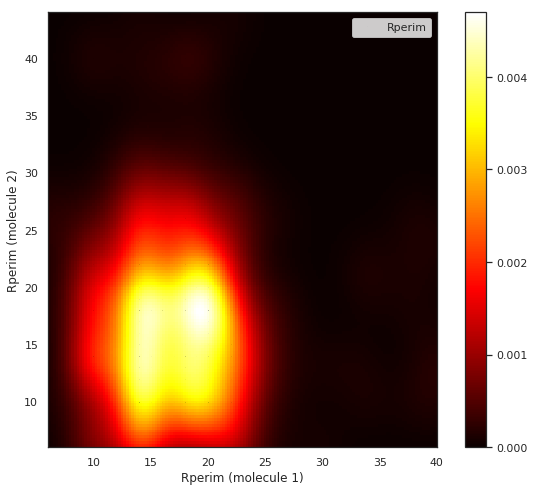

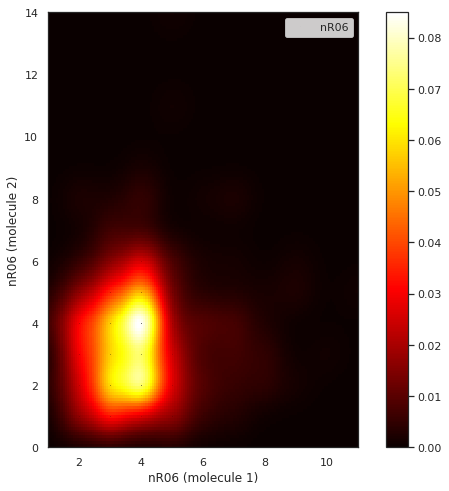

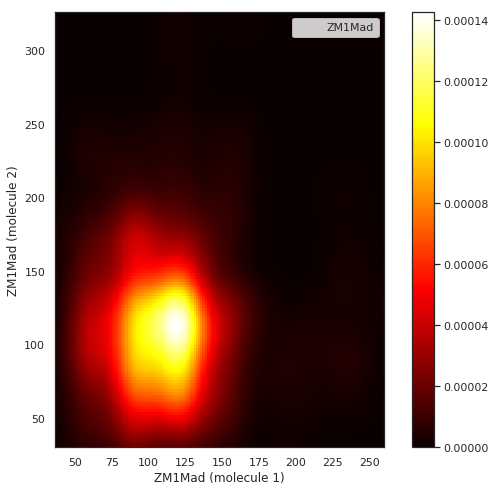

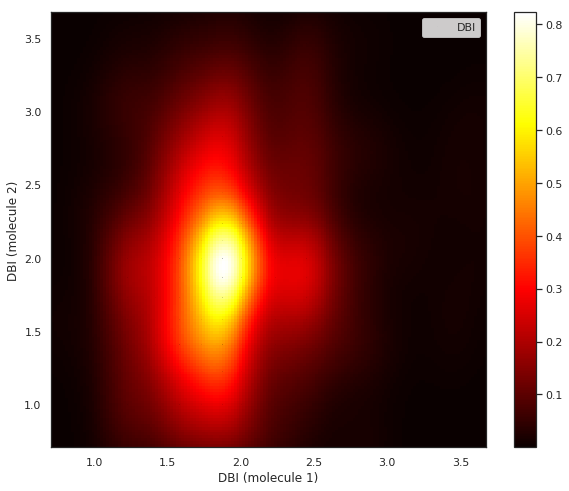

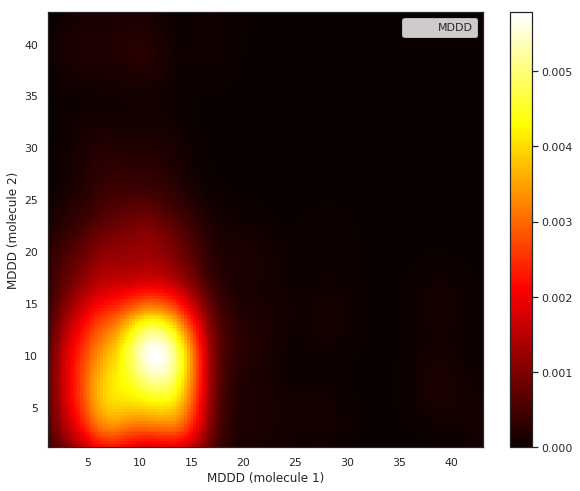

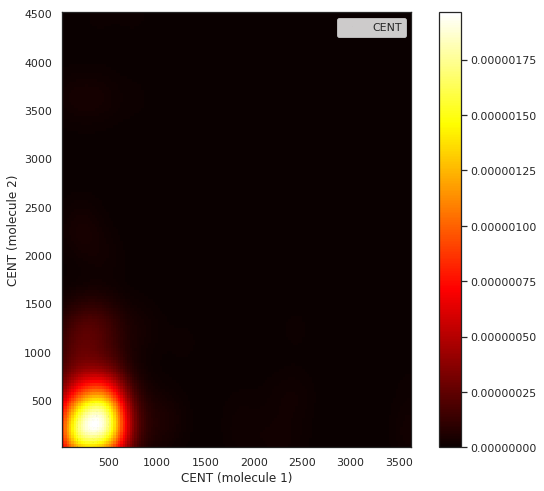

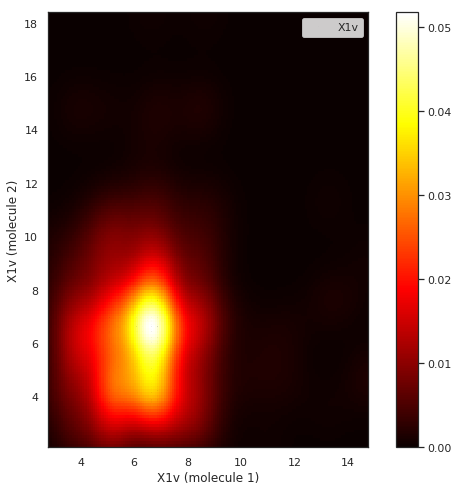

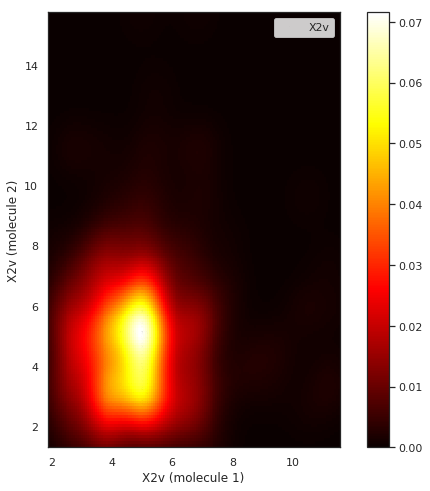

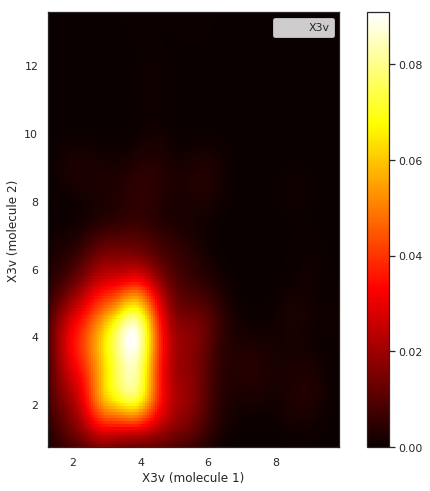

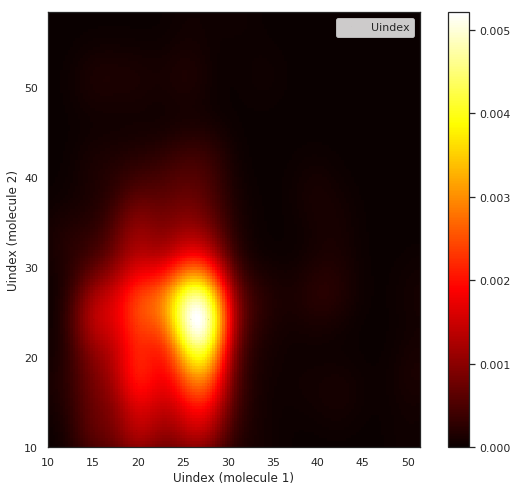

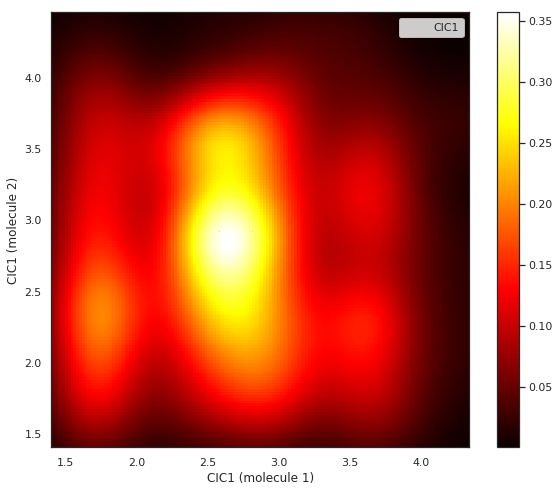

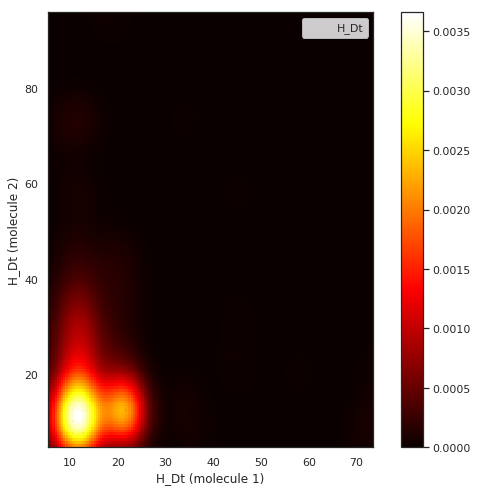

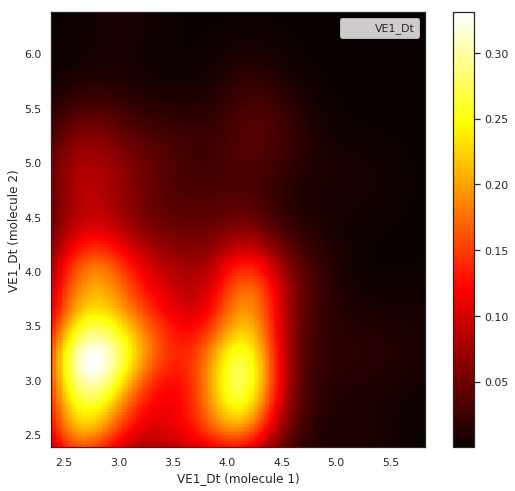

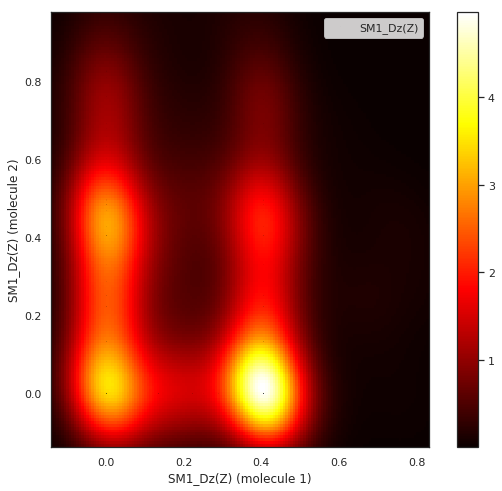

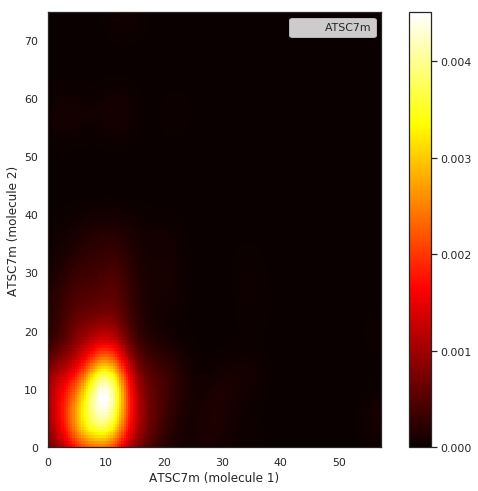

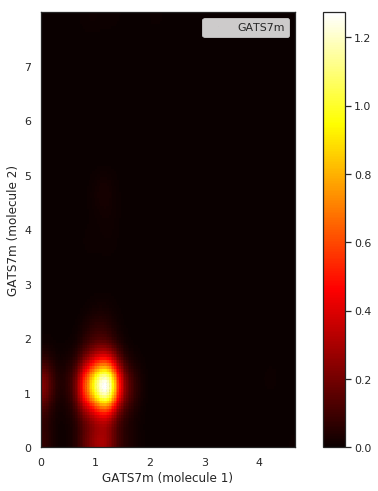

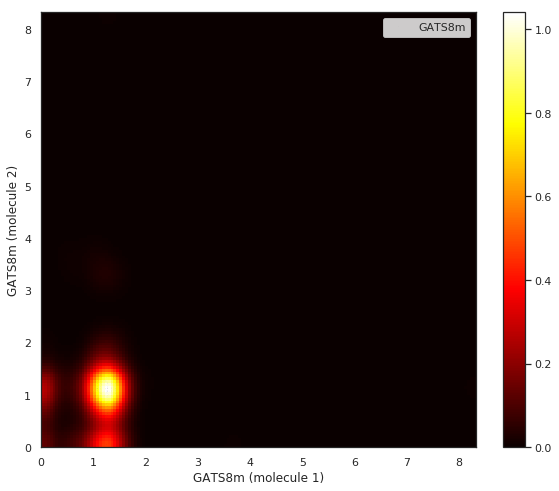

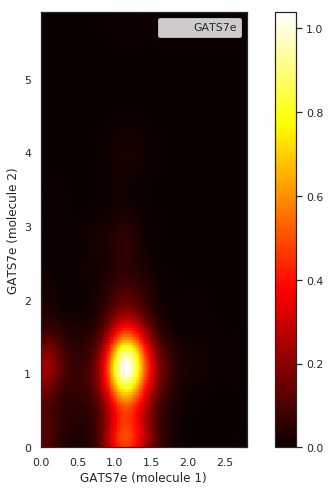

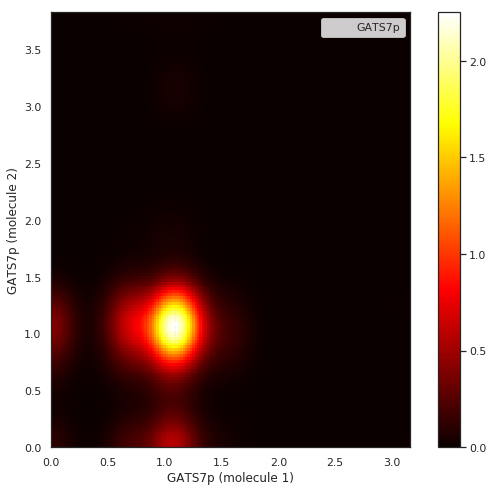

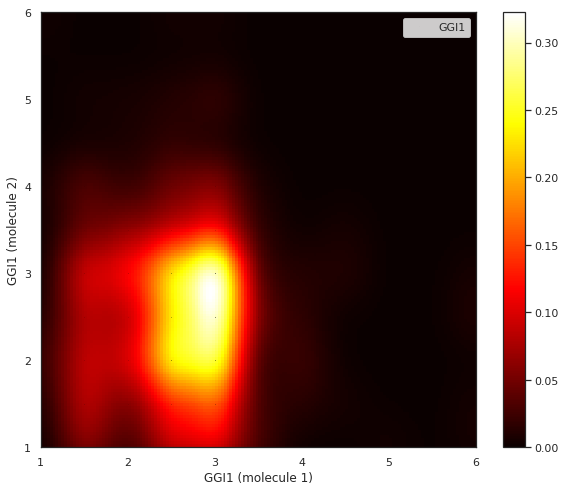

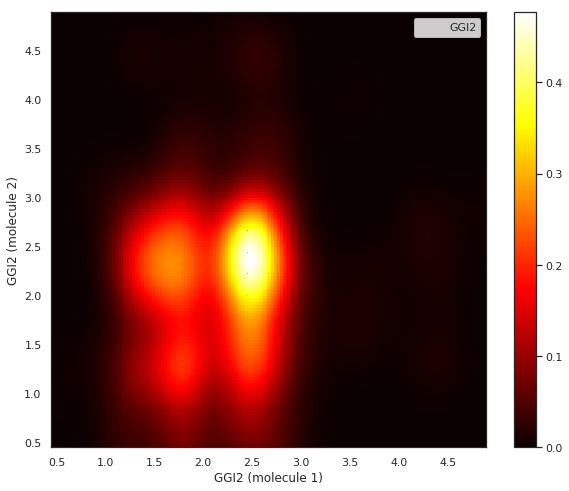

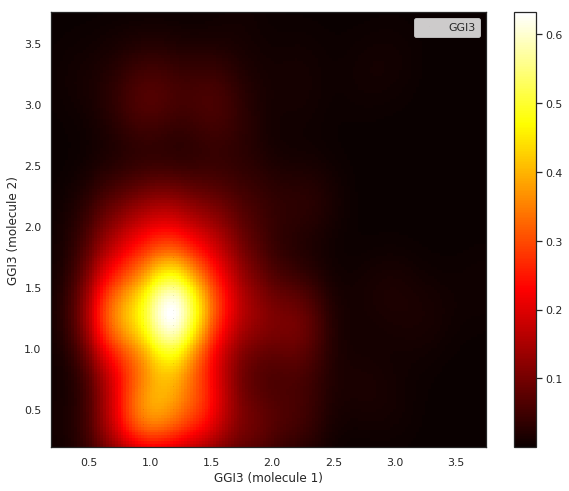

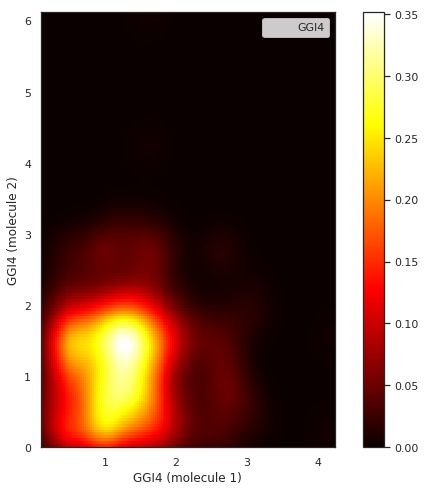

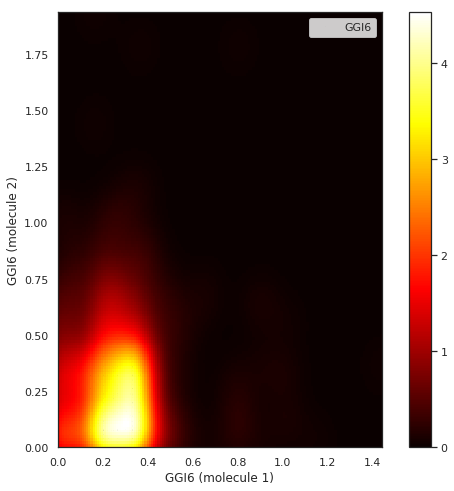

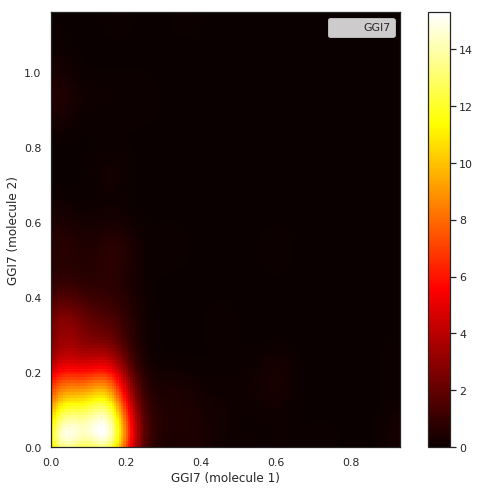

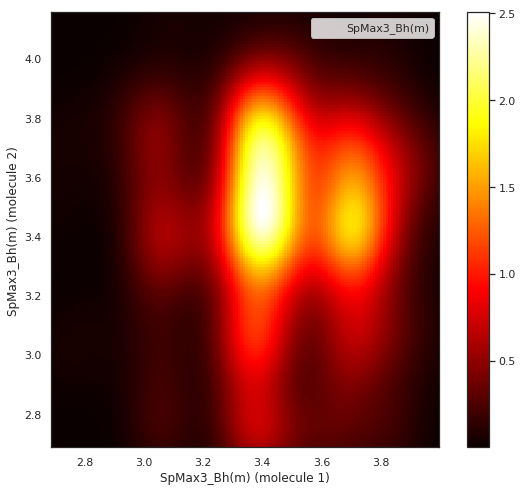

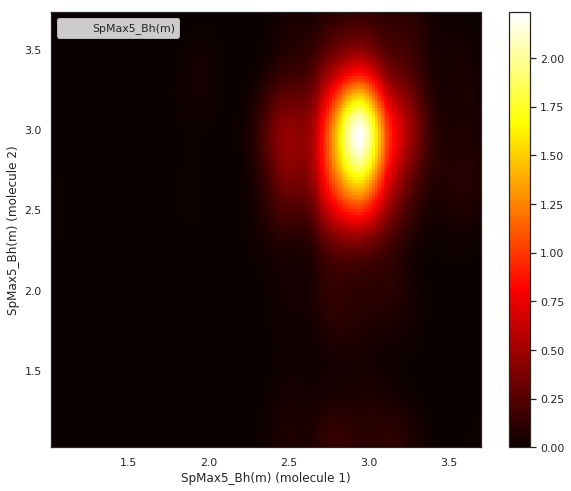

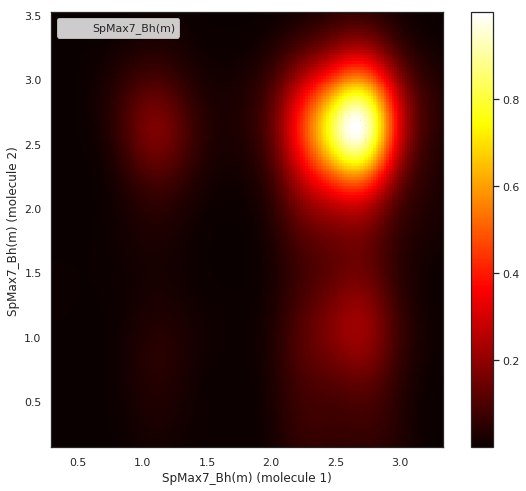

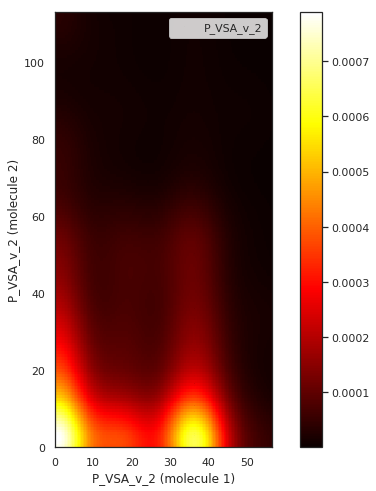

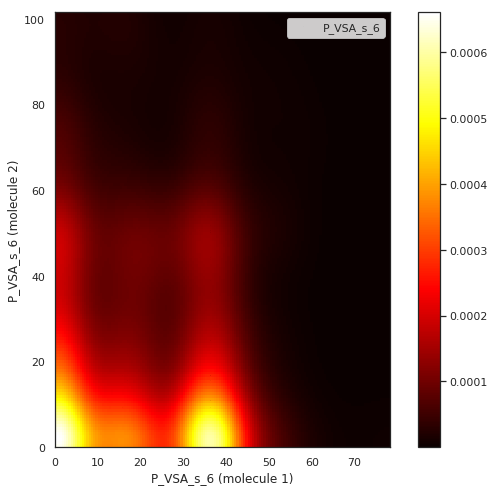

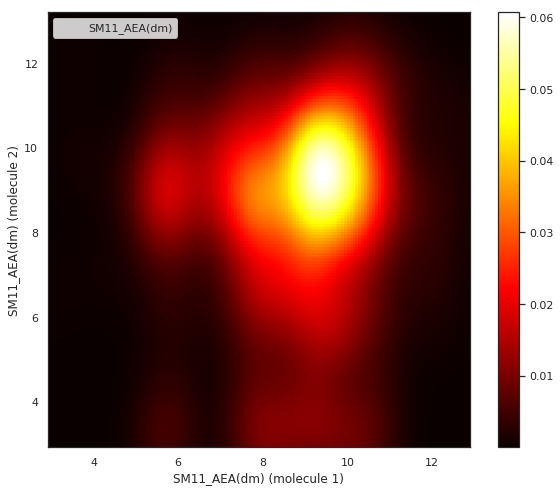

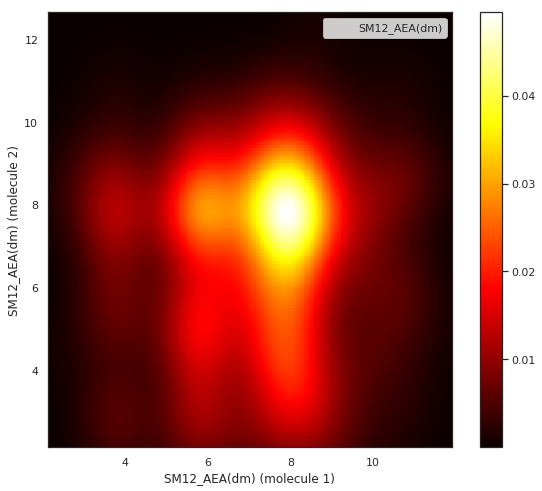

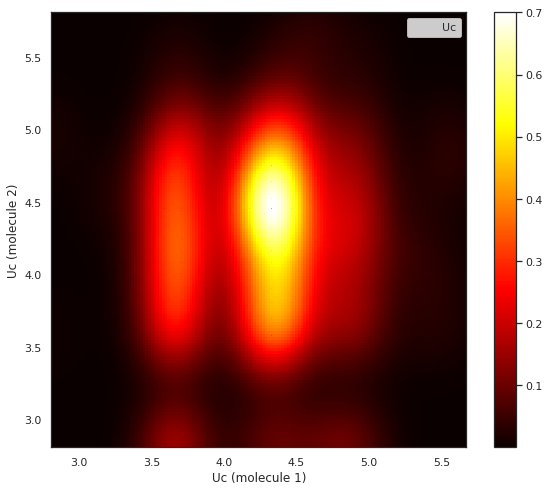

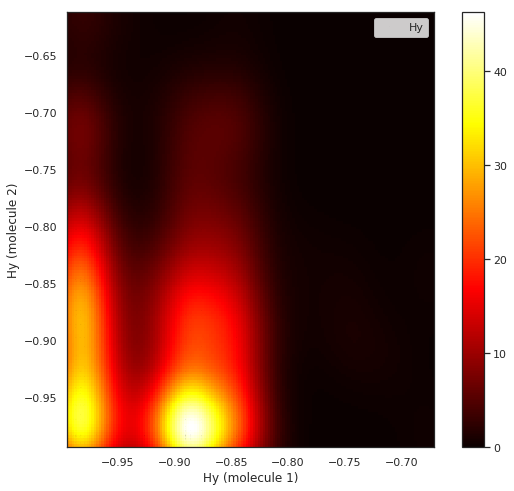

In [0]:
#fig, axes = plt.subplots(ncols=5, nrows=5, sharex=False, sharey=False, figsize=(10,10))
def den_plot(descriptor):
  m1=uf1[descriptor]
  m2=uf2[descriptor]
  xmin = m1.min()
  xmax = m1.max()
  ymin = m2.min()
  ymax = m2.max()
  X, Y = np.mgrid[xmin:xmax:150j, ymin:ymax:150j]
  
  
  positions = np.vstack([X.ravel(), Y.ravel()])
  values = np.vstack([m1, m2])
  kernel = stats.gaussian_kde(values)
  Z = np.reshape(kernel(positions).T, X.shape)

  # plot the result

  fig, ax = plt.subplots(figsize = (10,8))

  plt.imshow(np.rot90(Z), cmap=plt.cm.hot,
           extent=[xmin, xmax, ymin, ymax])

  plt.colorbar()
  ax.plot(m1, m2, 'k.', markersize=0.01)
  ax.set_xlim([xmin, xmax])
  ax.set_ylim([ymin, ymax])
  ax.grid(False)
  ax.legend()
  plt.xlabel("%s " % (descriptor) + '(molecule 1)')
  plt.ylabel("%s " % (descriptor) + '(molecule 2)')
  plt.show()
  #return plt


for i in uf1.columns.values:
  den_plot(i)

In [0]:
X_test[:, 0]

TypeError: ignored

In [0]:
# Fitting the algorithms in 2d to get a visualization, all the algortihms can be visualized in 2d except from the autoencoder, which needs higher dimensions as it measures the reconstruction error from higher to lower dimensions and back
from numpy import percentile
import matplotlib.font_manager
def make_plot(clf):
  outliers_fraction=0.06
  X_train= np.array(pd.concat([pd.DataFrame(pc_df)[0],pd.DataFrame(pc_df)[1]], axis=1))
  X_test= np.array(pd.concat([pd.DataFrame(pc_uf)[0],pd.DataFrame(pc_df)[1]], axis=1))
  plt.figure(figsize=(10, 10))
  xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))    
  clf.fit(X_train)
  scores_pred = clf.decision_function(X_train) * -1

  threshold = percentile(scores_pred, 100 * outliers_fraction)
        

  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)
       
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 10),
                         cmap=plt.cm.Blues_r)
  a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
  plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')

  b = plt.scatter(X_train[:, 0], X_train[:, 1], color='white',
                            s=20, edgecolor='k')
  #c = plt.scatter(X_test[:, 0], X_test[:, 1], c='black')


  
  plt.legend([a.collections[0], b],
           ["learned frontier", "training observations"], loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=13))


  plt.xlabel("%s" % clf_name)
  plt.axis('tight')
  plt.xlim((-2.5, 4))
  plt.ylim((-2, 2))
  plt.show()
  
#for i, (clf_name, clf) in enumerate(classifiers.items()):
    
 # make_plot(clf)

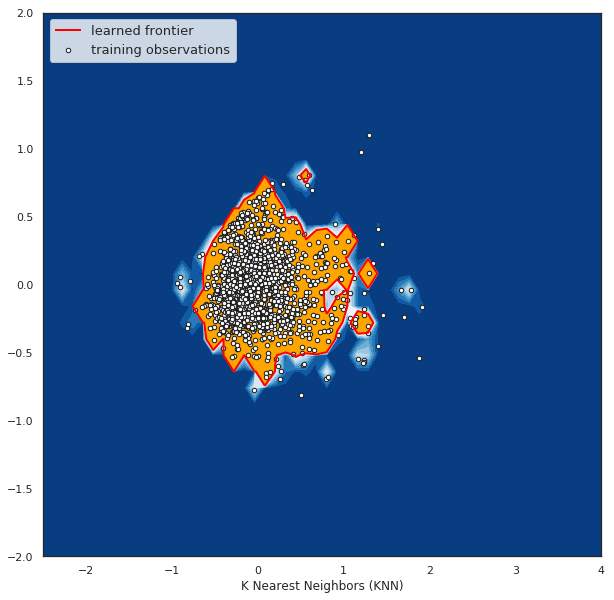

In [0]:
make_plot(ABOD(contamination=0.06))